Un video con resultados de este experimento esta en: https://youtube.com/shorts/mnR2g9tkh4k?feature=share

___

El objetivo de este notebook es el brindar ejemplos de acceso y uso de ambientes para simulación orientados al Reinforcement Learning (Aprendizaje por reforzamiento) mediante la libreria Gym. Link con documentacion: https://www.gymlibrary.dev/content/basic_usage/

**IMPORTANTE**: Para los primeros bloques con **Q-Learning** de codigo se requiere que la libreria **gym** tenga una version sugerida de **0.26** y para los bloques de **DeepQ** se requiere que sea menor, sugerido **0.25.2**

**EXPLICACIÓN**: La diferencia entre las versiones **0.25** y **0.26** se da en la cantidad de valores retornados al interactuar con el entorno, teniendo en la version **0.26** un dato más devuelto, pero la libreria **keras-rl** no es capaz de soportarlo en su versión disponible.

In [1]:
# [OBLIGATORIO] Librerias para TODO el notebook

import gym
import keyboard
import time
import numpy as np
import os
import shutil
import sys
from IPython.display import clear_output
import matplotlib.pyplot as plt
import cv2
import random
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

# Aplicación DeepQ

**Recordatorio**: Se requiere version **0.25 (antigua version)** de gym

In [2]:
# [OBLIGATORIO] librerias

import gym
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Input, Concatenate
from tensorflow.keras.layers import Conv2D, Conv3D
from tensorflow.keras.layers import MaxPooling2D, MaxPooling3D
from tensorflow.keras.layers import Dropout, Flatten, Reshape, Rescaling
from tensorflow.keras.layers import Cropping1D, Cropping2D, Cropping3D
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import softmax

from rl.agents.dqn import DQNAgent
from rl.agents import NAFAgent
from rl.agents import DDPGAgent
from rl.policy import EpsGreedyQPolicy
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory
from rl.agents import DDPGAgent
from rl.random import OrnsteinUhlenbeckProcess
from rl.random import GaussianWhiteNoiseProcess

# visualizar modelo
import visualkeras

In [3]:
# [SUGERIDO] Modificar clases de keras-rl para que pueda correr adecuadamente

# NOTA: Se puede utilizar Keras-RL segun codigo origen, pero puede que existan situaciones donde no funcione bien
# Para ver los cambios aplicados buscar el string en este bloque de codigos "## Modificado"

from rl.util import *

class Policy(object):
    """Abstract base class for all implemented policies.
    Each policy helps with selection of action to take on an environment.
    Do not use this abstract base class directly but instead use one of the concrete policies implemented.
    To implement your own policy, you have to implement the following methods:
    - `select_action`
    # Arguments
        agent (rl.core.Agent): Agent used
    """
    def _set_agent(self, agent):
        self.agent = agent

    @property
    def metrics_names(self):
        return []

    @property
    def metrics(self):
        return []

    def select_action(self, **kwargs):
        raise NotImplementedError()

    def get_config(self):
        """Return configuration of the policy
        # Returns
            Configuration as dict
        """
        return {}

class EpsGreedyQPolicy(Policy):
    """Implement the epsilon greedy policy
    Eps Greedy policy either:
    - takes a random action with probability epsilon
    - takes current best action with prob (1 - epsilon)
    """
    def __init__(self, eps=.1):
        super(EpsGreedyQPolicy, self).__init__()
        self.eps = eps

    def select_action(self, q_values):
        """Return the selected action
        # Arguments
            q_values (np.ndarray): List of the estimations of Q for each action
        # Returns
            Selection action
        """
        assert q_values.ndim == 1
        nb_actions = q_values.shape[0]

        if np.random.uniform() < self.eps:
            action = np.random.randint(0, nb_actions)
        else:
            ## Anterior
            ##action = np.argmax(q_values)
            
            ## Modificado
            vector = q_values
            action = np.random.choice(np.where(vector == np.max(vector))[0],1)[0]
            
        return action

    def get_config(self):
        """Return configurations of EpsGreedyQPolicy
        # Returns
            Dict of config
        """
        config = super(EpsGreedyQPolicy, self).get_config()
        config['eps'] = self.eps
        return config

class BoltzmannQPolicy(Policy):
    """Implement the Boltzmann Q Policy
    Boltzmann Q Policy builds a probability law on q values and returns
    an action selected randomly according to this law.
    """
    def __init__(self, tau=1., clip=(-1000., 1000.)):
        super(BoltzmannQPolicy, self).__init__()
        self.tau = tau
        self.clip = clip

    def select_action(self, q_values):
        """Return the selected action
        # Arguments
            q_values (np.ndarray): List of the estimations of Q for each action
        # Returns
            Selection action
        """
        assert q_values.ndim == 1
        q_values = q_values.astype('float64')
        nb_actions = q_values.shape[0]

        exp_values = np.exp(np.clip(q_values / self.tau, self.clip[0], self.clip[1]))
        probs = exp_values / np.sum(exp_values)
        action = np.random.choice(range(nb_actions), p=probs)
        return action

    def get_config(self):
        """Return configurations of BoltzmannQPolicy
        # Returns
            Dict of config
        """
        config = super(BoltzmannQPolicy, self).get_config()
        config['tau'] = self.tau
        config['clip'] = self.clip
        return config


class MaxBoltzmannQPolicy(Policy):
    """
    A combination of the eps-greedy and Boltzman q-policy.
    Wiering, M.: Explorations in Efficient Reinforcement Learning.
    PhD thesis, University of Amsterdam, Amsterdam (1999)
    https://pure.uva.nl/ws/files/3153478/8461_UBA003000033.pdf
    """
    def __init__(self, eps=.1, tau=1., clip=(-1000., 1000.)):
        super(MaxBoltzmannQPolicy, self).__init__()
        self.eps = eps
        self.tau = tau
        self.clip = clip

    def select_action(self, q_values):
        """Return the selected action
        The selected action follows the BoltzmannQPolicy with probability epsilon
        or return the Greedy Policy with probability (1 - epsilon)
        # Arguments
            q_values (np.ndarray): List of the estimations of Q for each action
        # Returns
            Selection action
        """
        assert q_values.ndim == 1
        q_values = q_values.astype('float64')
        nb_actions = q_values.shape[0]

        if np.random.uniform() < self.eps:
            exp_values = np.exp(np.clip(q_values / self.tau, self.clip[0], self.clip[1]))
            probs = exp_values / np.sum(exp_values)
            action = np.random.choice(range(nb_actions), p=probs)
        else:
            ## Anterior
            #action = np.argmax(q_values)
            
            ## Modificado
            vector = q_values
            action = np.random.choice(np.where(vector == np.max(vector))[0],1)[0]
        return action

    def get_config(self):
        """Return configurations of MaxBoltzmannQPolicy
        # Returns
            Dict of config
        """
        config = super(MaxBoltzmannQPolicy, self).get_config()
        config['eps'] = self.eps
        config['tau'] = self.tau
        config['clip'] = self.clip
        return config


class BoltzmannGumbelQPolicy(Policy):
    """Implements Boltzmann-Gumbel exploration (BGE) adapted for Q learning
    based on the paper Boltzmann Exploration Done Right
    (https://arxiv.org/pdf/1705.10257.pdf).
    BGE is invariant with respect to the mean of the rewards but not their
    variance. The parameter C, which defaults to 1, can be used to correct for
    this, and should be set to the least upper bound on the standard deviation
    of the rewards.
    BGE is only available for training, not testing. For testing purposes, you
    can achieve approximately the same result as BGE after training for N steps
    on K actions with parameter C by using the BoltzmannQPolicy and setting
    tau = C/sqrt(N/K)."""

    def __init__(self, C=1.0):
        assert C > 0, "BoltzmannGumbelQPolicy C parameter must be > 0, not " + repr(C)
        super(BoltzmannGumbelQPolicy, self).__init__()
        self.C = C
        self.action_counts = None

    def select_action(self, q_values):
        """Return the selected action
        # Arguments
            q_values (np.ndarray): List of the estimations of Q for each action
        # Returns
            Selection action
        """
        # We can't use BGE during testing, since we don't have access to the
        # action_counts at the end of training.
        assert self.agent.training, "BoltzmannGumbelQPolicy should only be used for training, not testing"

        assert q_values.ndim == 1, q_values.ndim
        q_values = q_values.astype('float64')

        # If we are starting training, we should reset the action_counts.
        # Otherwise, action_counts should already be initialized, since we
        # always do so when we begin training
        
        if self.agent.step == 0:
            self.action_counts = np.ones(q_values.shape)
        assert self.action_counts is not None, self.agent.step
        assert self.action_counts.shape == q_values.shape, (self.action_counts.shape, q_values.shape)

        beta = self.C/np.sqrt(self.action_counts)
        Z = np.random.gumbel(size=q_values.shape)

        perturbation = beta * Z
        perturbed_q_values = q_values + perturbation
        
        ## Anterior
        #action = np.argmax(perturbed_q_values)
        
        ## Modificado
        vector = perturbed_q_values
        action = np.random.choice(np.where(vector == np.max(vector))[0],1)[0]
        

        self.action_counts[action] += 1
        return action

    def get_config(self):
        """Return configurations of BoltzmannGumbelQPolicy
        # Returns
            Dict of config
        """
        config = super(BoltzmannGumbelQPolicy, self).get_config()
        config['C'] = self.C
        return config
    
class SoftmaxPolicy(Policy):
    """ Implement softmax policy for multinimial distribution
    Simple Policy
    - takes action according to the pobability distribution
    """
    def select_action(self, nb_actions, probs):
        """Return the selected action
        # Arguments
            probs (np.ndarray) : Probabilty for each action
        # Returns
            action
        """
        action = np.random.choice(range(nb_actions), p=probs)
        return action
    
class GreedyQPolicy(Policy):
    """Implement the greedy policy
    Greedy policy returns the current best action according to q_values
    """
    def select_action(self, q_values):
        """Return the selected action
        # Arguments
            q_values (np.ndarray): List of the estimations of Q for each action
        # Returns
            Selection action
        """
        assert q_values.ndim == 1
        
        ## Anterior
        #action = np.argmax(q_values)
        
        ## Modificado
        vector = q_values
        action = np.random.choice(np.where(vector == np.max(vector))[0],1)[0]
        
        return action

___

## Ambiente Car Racing

### 1) Discreto (fondo fijo)

NOTA: Previamente se realizaron entrenamiento de diversas versiones y la que se muestra aqui es la final encontrada. Esto significa que los parametros que se usan aqui son los mejores que se logró obtener de las multiples pruebas.

In [4]:
# [INFO GENERAL] valores del bloque

nom_env = "CarRacing" # nombre del entorno de simulacion
ver_modelo = 7       # version del bloque de modelo
ver_itera = 4        # numero de iteracion para la "version de modelo" 

# Crear carpeta para guardar pesos (posterior)
carpeta = nom_env + "_v" + str(ver_modelo) + "_"+ str(ver_itera) + "/"

print('Nombre entorno:',nom_env)
print('Version de modelo:',ver_modelo)
print('Version de iteracion:',ver_itera)
print('Direccion carpeta pesos:',carpeta)

Nombre entorno: CarRacing
Version de modelo: 7
Version de iteracion: 4
Direccion carpeta pesos: CarRacing_v7_4/


In [5]:
# [OBLIGATORIO] Leer entorno de simulacion - Inicializar

gym_env = "CarRacing-v2"
max_episode_steps = 1000
lap_percent = 0.85
semilla_env = 42
semilla_action = 42

# Cambiar aleatoriamente de color de pista
random_color_env = 0


# Inicializar ambiente
env = gym.make(gym_env, render_mode="rgb_array",continuous=False,
               lap_complete_percent=lap_percent,
               domain_randomize=random_color_env,
               max_episode_steps=max_episode_steps)


print('Escenario elegido de GymAI:',gym_env)
print('¿Colores aleatorios en ambiente?:',random_color_env)
print("Acciones del espacio:",env.action_space.n)
print('Semilla para entorno:',semilla_env)
print('Semilla para acciones:',semilla_action)
print('Maximos pasos por episodio:',max_episode_steps)
print('Porcentaje de vuelta [%]:',np.round(100.*lap_percent,2))

# Seteo de semilla inicio
env.action_space.seed(semilla_action)

if(random_color_env):
    observation = env.reset(seed=semilla_env,options={"randomize": random_color_env})
else:
    observation = env.reset(seed=semilla_env,options={"randomize": random_color_env})

# Cantidad de acciones
num_actions = env.action_space.n

Escenario elegido de GymAI: CarRacing-v2
¿Colores aleatorios en ambiente?: 0
Acciones del espacio: 5
Semilla para entorno: 42
Semilla para acciones: 42
Maximos pasos por episodio: 1000
Porcentaje de vuelta [%]: 85.0


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 96, 96, 3)         0         
                                                                 
 cropping2d (Cropping2D)     (None, 84, 96, 3)         0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


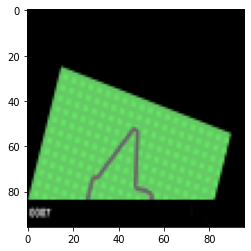

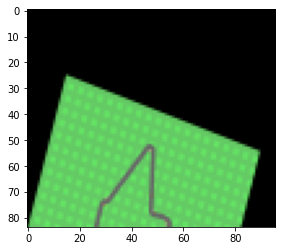

In [6]:
# [AUXILIAR - NO REQUERIDO] Validar recorte de imagen para eliminar margenes

# Se aplica la capa de recorte para reducir margenes no necesario de imagen

agent = Sequential()
agent.add(Reshape(env.observation_space.shape,input_shape=(1,) + env.observation_space.shape))
agent.add(Cropping2D(cropping=((0,12), (0,0))))
agent.summary()

##########################3

observationp, rewardp, terminatedp, _= env.step(env.action_space.sample())
plt.imshow(observationp)
plt.show()

observation = agent.predict(observationp[np.newaxis,np.newaxis,:,:])
plt.imshow(observation.astype("int")[0,:])
plt.show()

Los principales pasos para son:
- 1) Definir agente
- 2) Entrenamiento y validacion
- 3) Ver resultados
- 4) Ver modelo entrenado en aplicación

#### Opcion de modelos para el agente

In [6]:
# [MODELO] Definir e inicializar el agente de aprendizaje

# Es una alternativa donde se aplica recorte de imagen para eliminar los margenes

#####################################################
# [INFO] valores del bloque

nom_env = "CarRacing"           # nombre del entorno de simulacion
action_repetition_inicio = 6    # cantidad de pasos para el entrenamiento de agente
action_repetition_final = 3     # cantidad de pasos luego de haber entrenado # epochs

# Crear carpeta para guardar pesos (posterior)
carpeta = nom_env + "_v" + str(ver_modelo) + "_"+ str(ver_itera) + "/"

print('Nombre entorno:',nom_env)
print('Version de modelo:',ver_modelo)
print('Version de iteracion:',ver_itera)
print('Action repetition inicio:',action_repetition_inicio)
print('Action repetition final :',action_repetition_final)
print('Direccion carpeta pesos:',carpeta)
print('-----------------------------------------------\n')

#####################################################

agent = Sequential()
agent.add(Reshape(env.observation_space.shape,input_shape=(1,) + env.observation_space.shape))
agent.add(Cropping2D(cropping=((0,12), (0,0))))
agent.add(Rescaling(scale=1./255., offset=0.0)) 

agent.add(Conv2D(128, (3,3))) 
agent.add(Activation('relu'))
agent.add(MaxPooling2D(pool_size=(2, 2)))
agent.add(Dropout(0.2))

agent.add(Conv2D(128, (3,3)))
agent.add(Activation('relu'))
agent.add(MaxPooling2D(pool_size=(2, 2)))
agent.add(Dropout(0.2))

agent.add(Conv2D(64, (3,3)))
agent.add(Activation('relu'))
agent.add(MaxPooling2D(pool_size=(2, 2)))
agent.add(Dropout(0.1))

agent.add(Conv2D(64, (3,3)))
agent.add(Activation('relu'))
agent.add(MaxPooling2D(pool_size=(2, 2)))

agent.add(Conv2D(64,(3,3)))
agent.add(Activation('relu'))

agent.add(Flatten())

agent.add(Dense(16,activation="elu",
                kernel_regularizer=regularizers.L2(1e-4),
                bias_regularizer= regularizers.L2(1e-4)))

agent.add(Dense(num_actions,activation="linear",name="output"))

# ver modelo
agent.summary()

Nombre entorno: CarRacing
Version de modelo: 7
Version de iteracion: 4
Action repetition inicio: 6
Action repetition final : 3
Direccion carpeta pesos: CarRacing_v7_4/
-----------------------------------------------

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 96, 96, 3)         0         
                                                                 
 cropping2d (Cropping2D)     (None, 84, 96, 3)         0         
                                                                 
 rescaling (Rescaling)       (None, 84, 96, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 82, 94, 128)       3584      
                                                                 
 activation (Activation)     (None, 82, 94, 128)       0         
                                     

#### Entrenamiento y validacion

In [8]:
# [DEFINIR FUNCIONES] Definir funciones para evaluar y visualizar el modelo entrenado

# Definir funcion de visualizacion y evaluacion de modelo
def visualiza_test(dqnp,gym_evn= "CarRacing-v2",
                   eps_actua = 0.05,
                   n_pasos= 1300,
                   n_pasos_total= 5000,
                   max_episodios= 5,
                   lap_percent= 0.90,
                   seed_env= semilla_env,
                   seed_action= semilla_action,
                   accion_adelanta = 3, # indicar valor para accion de "avanzar"
                   accion_retrocede = 4, # indicar valor para accion de "retroceder"
                   n_pasos_limite_adelante = 10, # cantidad maxima de pasos "adelante" para aplicar medida de freno (retroceso)
                   n_pasos_reinicia_otro = 10,  # segun la cantidad de pasos seguidos "adelante" reinicia contrador "otro"
                   n_pasos_reinicia_adelante = 4, # segun la cantidad de pasos seguidos "otro" reinicia contrador "adelante"
                   random_color_envp = False,  # cambiar aleatoriamente el color de fondo
                   imprime= False):
    
    # Valor inicial de eps de "strategy" (para evitar modificar de forma irreversible)
    eps_inicial = dqnp.policy.eps
    
    # Para moverse aplicar eps_actua
    dqnp.policy.eps = eps_actua
    
    # crea entorno
    envp = gym.make(gym_env, render_mode="human",
                    continuous=False,
                    lap_complete_percent=lap_percent,
                    domain_randomize=random_color_envp,
                    max_episode_steps=n_pasos)
    
    # Seteo de semilla de inicio
    envp.action_space.seed(seed_action)
    
    if(random_color_envp):
        observationp = envp.reset(seed=seed_env,options={"randomize": random_color_envp})
    else:
        observationp = envp.reset(seed=seed_env,options={"randomize": random_color_envp})
    
    
    # seguimiento de recompensa
    suma_reward = 0
    episodios = 0
    
    #################
    ## Medidas de control para limitar velocidad
    
    # Registrar cuantas veces seguidas se aplica hacia "adelante"
    n_pasos_avanza_seguidos = 0
    
    # Registrar cuantas veces seguidas se aplica otra accion diferente de "adelante"
    n_pasos_no_avanza = 0
    #################
    
    
    # Recorrer los n_pasos
    for i in range(n_pasos_total):
        
        ### Prediccion de accion actual
        action_actual = dqnp.forward(observationp)
        
        
        #################################
        ## [COMPLEMENTO] Limitantes impuestas para evitar sobre-velocidad
        
        ## Esta aplicando accion hacia "adelante"
        if(action_actual == accion_adelanta):
            
            # Conteo de avance seguido
            n_pasos_avanza_seguidos += 1
            
            if(n_pasos_avanza_seguidos >= n_pasos_reinicia_otro):
                # Reinicia al contador de "otros"
                n_pasos_no_avanza = 0
            
        else:
            ### Esta aplicando una accion diferente a "adelante"
            n_pasos_no_avanza += 1
            
            if(n_pasos_no_avanza >= n_pasos_reinicia_adelante):
                # Reinicia al contador de "adelante"
                n_pasos_avanza_seguidos = 0
        
        # En caso se supere el limite aplicar estrategia de limitacion
        if(n_pasos_avanza_seguidos >= n_pasos_limite_adelante):
            
            # Indicar que la acccion a aplicar será de retroceso
            action_actual = accion_retrocede
            
            # reiniciar conteo de pasos
            n_pasos_avanza_seguidos = 0
            n_pasos_no_avanza = 0
        
        
        ################################
        ## Aplica accion y actualiza estados
        
        observationp, rewardp, terminatedp, _ = envp.step(action_actual)
        
        # Suma total de recompensas
        suma_reward += rewardp
        
        #################################
        
        ## Observado - Interaccion
        if(imprime):
            print('i:',i,';reward:',np.round(rewardp,2),';terminado:',terminatedp,' ; total reward:',np.round(rewardp,2))

        # En caso haya logrado alcanzar el objetivo se indica
        if terminatedp:
            
            # Reiniciar ambiente
            if(random_color_envp):
                observationp = envp.reset(seed=seed_env,options={"randomize": random_color_envp})
            else:
                observationp = envp.reset(seed=seed_env,options={"randomize": random_color_envp})

            # Calculo reward
            suma_reward = 0
            
            episodios +=1
            if(episodios >= max_episodios):
                break

    # Cerrar entorno
    envp.close()
    
    # Retornar a valor inicial de "eps"
    dqnp.policy.eps = eps_inicial


# Definir funcion de visualizacion y registro de metricas de rendimiento
def visualiza_test2(dqnp,gym_evn= "CarRacing-v2",
                    eps_actua= 0.05,
                    n_pasos= 1500,
                    max_episodios= 5,
                    lap_percent= 0.90,
                    seed_env= semilla_env,
                    seed_action= semilla_action,
                    random_color_envp = False,  # cambiar aleatoriamente el color de fondo
                    imprime= False):
    
    # Valor inicial de eps de "strategy" (para evitar modificar de forma irreversible)
    eps_inicial = dqnp.policy.eps
    
    # Para moverse aplicar eps_actua
    dqnp.policy.eps = eps_actua
    
    # crea entorno
    envp = gym.make(gym_env, render_mode="human",
                    continuous=False,
                    lap_complete_percent=lap_percent,
                    domain_randomize=random_color_envp,
                    max_episode_steps=n_pasos)
    
    # Seteo de semilla de inicio
    envp.action_space.seed(seed_action)
    
    # Reiniciar ambiente
    if(random_color_envp):
        observationp = envp.reset(seed=seed_env,options={"randomize": random_color_envp})
    else:
        observationp = envp.reset(seed=seed_env,options={"randomize": random_color_envp})
    
    # Reiniciar valores
    suma_reward = 0
    episodios = 0
    
    # cantidad de pasos en episodio actual
    episodio_ii = 0
    
    # Inicializar variables de rendimiento de episodio
    promedio_reward = None
    total_reward = None
    num_pasos = None
    
    # Recorrer los n_pasos
    for i in range(n_pasos):
        observationp, rewardp, terminatedp, _ = envp.step(dqnp.forward(observationp))
        
        # Suma total de recompensas
        suma_reward += rewardp
        
        # contador de pasos
        episodio_ii +=1

        ## Observado - Interaccion
        if(imprime):
            print('i:',i,';reward:',np.round(rewardp,2),';terminado:',terminatedp,' ; total reward:',np.round(rewardp,2))

        # En caso haya logrado alcanzar el objetivo se indica
        if terminatedp:
            
            # Calculo de valores del ultimo episodio finalizado
            promedio_reward = 1.*suma_reward/episodio_ii
            total_reward = 1.*suma_reward
            num_pasos = episodio_ii
            
            # Reiniciar ambiente
            if(random_color_envp):
                observationp = envp.reset(seed=seed_env,options={"randomize": random_color_envp})
            else:
                observationp = envp.reset(seed=seed_env,options={"randomize": random_color_envp})
            
            
            # Reiniciar valores
            suma_reward = 0
            episodio_ii = 0
            
            # cantidad de episodios terminados
            episodios +=1
            if(episodios >= max_episodios):
                # finaliza bucle for
                break

    # Cerrar entorno
    envp.close()
    
    # Retornar a valor inicial de "eps"
    dqnp.policy.eps = eps_inicial
    
    # retorna valores
    return [num_pasos,promedio_reward,total_reward]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 96, 96, 3)         0         
                                                                 
 cropping2d (Cropping2D)     (None, 84, 96, 3)         0         
                                                                 
 rescaling (Rescaling)       (None, 84, 96, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 82, 94, 128)       3584      
                                                                 
 activation (Activation)     (None, 82, 94, 128)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 41, 47, 128)      0         
 )                                                               
                                                        

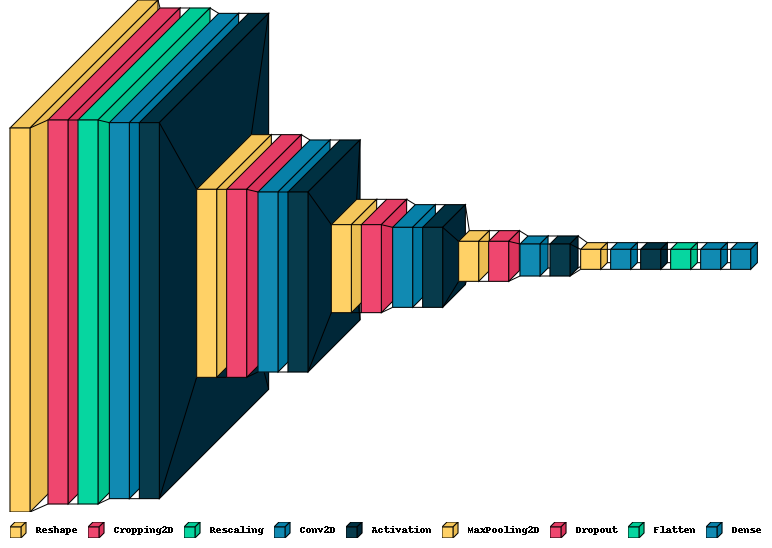

In [9]:
# [VISUALIZAR] Mostrar modelo de agente (DeepQ)
agent.summary()
visualkeras.layered_view(agent,legend=True)

**Entrenamiento de agente (DeepQ)**

In [11]:
# [NO ENTRENA - SOLO PARA TESTEO] Inicializar agente para testeo

##################################################################################
## NOTA: Tener mucho cuidado con la configuración de las 4 primeras variables ####
##################################################################################

# Indicar si se va entrenar o solo definir agente y parametros (util para testeo simulacion)
entrenar_agente = 0

####################
# En caso si se dese entrenar (entrenar == 1)

# Version de pesos a re-entrenar ("wgt_trainedM_") se añade la version "M" al nombre de archivo
version_pesos_retrain = "2"         # NOTA: A veces el inicio podria tener valor "" (vacio)

# [Tener cuidado!!!] borrar carpeta - en caso exista
borrar_carpeta = 0    # 0: No borra, 1: Borrar

# Indicar si se va inicializar el agente (En caso ya este cargado el agente quizas no se desee inicializar)
inicializar_agente = 1

# (1): Definir modelo inicial ("wgt_") / (0): Continuar entrenando modelo ("wgt_trainedM_")
entrenar_inicio = 0

################################
# Borrado/Creacion de carpeta

print('Borrar carpeta en caso exista? [0:No, 1:Si]:',borrar_carpeta)
if(borrar_carpeta):
    try:
        shutil.rmtree(carpeta)
        print('[Informativo] Se pudo borrar carpeta ')
    except:
        print('[Informativo] No se pudo borrar carpeta')

# Crear carpeta para guardar pesos de modelos
os.makedirs(carpeta,exist_ok=True)
######################

# En cada training nuevo empezar el ambiente de forma aleatoria
env_inicio_aleatorio = 0

# Pasos maximos para testeo con modelo entrenado
n_pasos_test = 800

# Pasos de calentamiento en cada episodio (nb_steps_warmup)
n_pasos_warmup_inicio = 25
n_pasos_warmup_posterior = 3

# Cantidad de pasos seguidos a guardar (Memory_Limit)
memory_limit = 25

# Teclado a presionar para finalizar
teclado = "t"

# Informativo
print('Iniciar entrenamiento de agente o usar ya entrenado:',entrenar_inicio)

# IMPORTANTE, segun el valor de "entrenar_inicio"
## [0] : Se guardan los pesos en archivo "wtg_trained"
## [1] : Se guardan los pesos en archivo "wtg_"
## Se entiende que el "trained" es cuando se entrena un modelo previamente entrenado


# [INFORMATIVO] Nombre de carpeta y archivo
if(entrenar_inicio):
    print('Archivo a leer/escribir pesos de modelo:',carpeta + "wgt_EPOCH"  + ".h5f")
else:
    print('Archivo a leer/escribir pesos de modelo:',carpeta + "wgt_" + str(version_pesos_retrain)  + "_EPOCH"  + ".h5f")

#######################################################
#######################################################
## Definir e inicializar agente (DeepQ) ####

if(inicializar_agente):
    
    ### 1) Estrategia para determinar la accion del agente
    strategy = EpsGreedyQPolicy()
    #strategy = MaxBoltzmannQPolicy()
    

    ### 2) Memoria: cantidad de pasos a registrar
    memory = SequentialMemory(limit = memory_limit, window_length = 1)

    ### 3) Agente DeepQ
    dqn = DQNAgent(
        model = agent, 
        nb_actions = num_actions,
        memory = memory, 
        nb_steps_warmup = n_pasos_warmup_inicio,
        target_model_update = 5e-2,
        enable_double_dqn=False,
        enable_dueling_network=False,
        dueling_type = "max",
        policy = strategy
    )

    ### 4) Indicar compilador Tensorflow (Algoritmo iterativo de aprendizaje y metrica de evaluacion)
    lr = 2e-3
    dqn.compile(Adam(lr=lr), metrics =['mse'])
    print('[INFO] Se definió variable "dqn" con agente')

    
#######################################################
#######################################################
### Definir parametros de entrenamiento ###


if(entrenar_inicio): 
    ## A) INICIO ENTRENAMIENTO DE AGENTE (No entrenado previamente) ##
    
    ## Visualizar el entrenamiento inicial
    epochs_total = 40000 
    epochs_delta = 80   
    epochs_viz = 80      
    epochs_viz_actual = epochs_viz  # inicializar
    
    ## Parametros de epsilon para el entrenamiento
    eps_inicio = 0.40               
    eps_final  = 0.10               
    eps_ratio_decrece = 1./1000     
    dqn.policy.eps = eps_inicio
    
    # Inicializar el valor de repiticion de pasos por accion
    action_repetition = action_repetition_inicio
    
else:
    ## B) AGENTE YA ENTRENADO (Continuar entrenando) ##
    
    ## Ya se tiene modelo entrenado y se desea continuar
    epochs_total = 8000     
    epochs_delta = 80       
    epochs_viz = 80        
    epochs_viz_actual = epochs_viz  # inicializar
    
    ## Indicar la cantidad de pasos de calentamiento (np_step_warmup)
    dqn.nb_steps_warmup = n_pasos_warmup_posterior
    
    ## Parametros de epsilon para el entrenamiento
    eps_inicio = 0.125            
    eps_final  = 0.075           
    eps_ratio_decrece = 1./1000  
    dqn.policy.eps = eps_inicio   
    
    # Inicializar el valor de repiticion de pasos por accion -- NOTA: usar valor final
    action_repetition_inicio = 4
    action_repetition_final= action_repetition_inicio
    
    # actualizar valor actual
    action_repetition = action_repetition_inicio
    
    # Indicar learning rate del optimizador
    lr = 1e-4
    dqn.compile(Adam(lr=lr), metrics =['mse'])

#######################################################
#######################################################
### Entrenamiento ####

# Si se va entrenar
if(entrenar_agente):

    # Guardar valor de "eps"
    eps_ultimo = dqn.policy.eps

    # Seguimiento de modelos entrenados y registrados durante entrenamiento
    resultado_fit = pd.DataFrame()
    indice_fit = 0
    
    # Indicar el nombre del archivo de pesos del modelo "padre" previamente entrenado
    if(not entrenar_inicio):
        try:
            archivo_pesos_origen = archivo_lee
        except:
            archivo_pesos_origen = ""
    else:
        archivo_pesos_origen = ""

    ###########################
    
    
    ### [Principal] Bucle principal de entrenamiento
    for num_epoch in range(0,epochs_total,epochs_delta):

        # Colocar valor ultimo de "eps"
        dqn.policy.eps = eps_ultimo
        eps = eps_ultimo  # actualiza

        # Actualizar parametro pero no al inicio del bucle for, sino en la segunda iteracion
        if(num_epoch > 0):

            # parametro de pasos_warmup
            dqn.nb_steps_warmup = n_pasos_warmup_posterior


            ### Actualizar epsilon de busqueda aleatoria vs greedy
            ##eps = max(eps_final,eps*(eps_ratio_decrece**(epochs_delta/100.0)))  # No puede ser menor a "eps_final"
            eps = max(eps_final, (1.0*eps) - ((eps_ratio_decrece*epochs_delta)**2))  # No puede ser menor a "eps_final"
            dqn.policy.eps = eps


            # Condicion limite - actualizar cantidad de pasos por accion
            if(eps <= eps_final):    
                # Cambiar el numero de pasos de repiticion de accion
                action_repetition = action_repetition_final


        ##################

        # Informativo
        print('Valores :: de action_repetition:',action_repetition,' ; eps:',np.round(eps,6),' ; nb_steps_warmup:',dqn.nb_steps_warmup)

        # Entrenar modelo
        dqn.fit(env,nb_steps=epochs_delta, visualize = False, verbose=2, action_repetition=action_repetition)

        # Guardar ultimo valor de "eps"
        eps_ultimo = dqn.policy.eps

        ###################

        # finalizar ejecución - presione teclado
        if keyboard.is_pressed(teclado):
            break

        ###################

        # Visualizar segun entrenado - permite hacer seguimiento y entendimiento del aprendizaje del agente
        if(num_epoch + epochs_delta >= epochs_viz_actual):

            # borrar salida de consola (evitar saturar memoria)
            clear_output()

            print('  -----  VISUALIZA ESTADO (EPOCH: ' + str(num_epoch + epochs_delta) + ') ------- ')

            ##################

            ### Testeo con agente entrenado ##
            eps_actua_test = eps_ultimo  # guarda ultimo valor de "eps"

            valores_reward = visualiza_test2(dqn,gym_evn=gym_env,
                                             n_pasos=n_pasos_test,
                                             eps_actua = eps_actua_test,
                                             max_episodios=1,
                                             lap_percent=lap_percent)

            epochs_viz_actual += epochs_viz # actualiza el siguiente punto de testeo/visualizacion

            # Agregar resultados
            resultado_fit.loc[indice_fit,["indice","epoch"]] = [indice_fit,num_epoch]
            resultado_fit.loc[indice_fit,["eps_train","eps_test","pasos_act_repet","pasos_warmpup"]] = [eps_ultimo,eps_actua_test,action_repetition,dqn.nb_steps_warmup]
            resultado_fit.loc[indice_fit,["num_pasos","rew_mean","rew_total"]] = valores_reward
            
            
            #################

            # Guardar pesos del modelo en archivo
            if(entrenar_inicio):
                archivo_pesos_modelo = carpeta + "wgt_" + str(num_epoch) + ".h5f"
            else:
                archivo_pesos_modelo = carpeta + "wgt_trained" + str(version_pesos_retrain) + "_" + str(num_epoch) + ".h5f"

            # guardar y actualizar
            dqn.save_weights(archivo_pesos_modelo, overwrite=True)
            resultado_fit.loc[indice_fit,"archivo"] = archivo_pesos_modelo
            resultado_fit.loc[indice_fit,"pesos_origen"] = archivo_pesos_origen  # archivo de pesos origen [trazabilidad]
            print('[INFO] Archivo pesos modelo entrenado:',archivo_pesos_modelo)
            indice_fit += 1  # aumenta cuenta de peso de modelos registrados (indice en dataframe resultante)
            
            ######################
            
            # Imprimir la tabla de los 5 mejores "total reward"
            print(resultado_fit.sort_values(["rew_total","num_pasos"],ascending=[False,True]).head(4))

            
        ##########################

        # Antes de volver a entrenar - reiniciar entorno de simulacion
        if(env_inicio_aleatorio):

            # Segun parametros inicializar el entorno
            env = gym.make(gym_env, render_mode="rgb_array",
                           continuous=False,
                           lap_complete_percent=lap_percent,
                           domain_randomize=random_color_env,
                           max_episode_steps=max_episode_steps)

            # Indicar semilla de aleatoriedad
            env.action_space.seed(semilla_action)
        
        ############################
        # Elegir aleatoriamente color de ambiente
        if(random_color_env):
            observation = env.reset(seed=semilla_env,options={"randomize": random_color_env})
        else:
            observation = env.reset(seed=semilla_env,options={"randomize": random_color_env})
        
        
else:
    print('No se va entrenar agente - solo se inicializó')


#######################################################
#######################################################
print('Finalizacion de entrenamiento')

Borrar carpeta en caso exista? [0:No, 1:Si]: 0
Iniciar entrenamiento de agente o usar ya entrenado: 0
Archivo a leer/escribir pesos de modelo: CarRacing_v7_4/wgt_2_EPOCH.h5f
[INFO] Se definió variable "dqn" con agente
No se va entrenar agente - solo se inicializó
Finalizacion de entrenamiento


In [ ]:
# [SOLO ENTRENAMIENTO] Crear modelo para encontrar la estrategia optima

##################################################################################
## NOTA: Tener mucho cuidado con la configuración de las 4 primeras variables ####
##################################################################################

# Indicar si se va entrenar o solo definir agente y parametros (util para testeo simulacion)
entrenar_agente = 1

####################
# En caso si se dese entrenar (entrenar == 1)

# Version de pesos a re-entrenar ("wgt_trainedM_") se añade la version "M" al nombre de archivo
version_pesos_retrain = "2"         # NOTA: A veces el inicio podria tener valor "" (vacio)

# [Tener cuidado!!!] borrar carpeta - en caso exista
borrar_carpeta = 0    # 0: No borra, 1: Borrar

# Indicar si se va inicializar el agente (En caso ya este cargado el agente quizas no se desee inicializar)
inicializar_agente = 1

# (1): Definir modelo inicial ("wgt_") / (0): Continuar entrenando modelo ("wgt_trainedM_")
entrenar_inicio = 0

###############################
# Borrado/Creacion de carpeta

print('Borrar carpeta en caso exista? [0:No, 1:Si]:',borrar_carpeta)
if(borrar_carpeta):
    try:
        shutil.rmtree(carpeta)
        print('[Informativo] Se pudo borrar carpeta ')
    except:
        print('[Informativo] No se pudo borrar carpeta')

# Crear carpeta para guardar pesos de modelos
os.makedirs(carpeta,exist_ok=True)
######################

# En cada training nuevo empezar el ambiente de forma aleatoria
env_inicio_aleatorio = 0

# Pasos maximos para testeo con modelo entrenado
n_pasos_test = 800

# Pasos de calentamiento en cada episodio (nb_steps_warmup)
n_pasos_warmup_inicio = 25
n_pasos_warmup_posterior = 3

# Cantidad de pasos seguidos a guardar (Memory_Limit)
memory_limit = 25

# Teclado a presionar para finalizar
teclado = "t"

# Informativo
print('Iniciar entrenamiento de agente o usar ya entrenado:',entrenar_inicio)

# IMPORTANTE, segun el valor de "entrenar_inicio"
## [0] : Se guardan los pesos en archivo "wtg_trained"
## [1] : Se guardan los pesos en archivo "wtg_"
## Se entiende que el "trained" es cuando se entrena un modelo previamente entrenado

# [INFORMATIVO] Nombre de carpeta y archivo
if(entrenar_inicio):
    print('Archivo a leer/escribir pesos de modelo:',carpeta + "wgt_EPOCH"  + ".h5f")
else:
    print('Archivo a leer/escribir pesos de modelo:',carpeta + "wgt_" + str(version_pesos_retrain)  + "_EPOCH"  + ".h5f")
    
#######################################################
#######################################################
## Definir e inicializar agente (DeepQ) ####

if(inicializar_agente):
    
    ### 1) Estrategia para determinar la accion del agente
    strategy = EpsGreedyQPolicy()
    #strategy = MaxBoltzmannQPolicy()
    

    ### 2) Memoria: cantidad de pasos a registrar
    memory = SequentialMemory(limit = memory_limit, window_length = 1)

    ### 3) Agente DeepQ
    dqn = DQNAgent(
        model = agent, 
        nb_actions = num_actions,
        memory = memory, 
        nb_steps_warmup = n_pasos_warmup_inicio,
        target_model_update = 5e-2,
        enable_double_dqn=False,
        enable_dueling_network=False,
        dueling_type = "max",
        policy = strategy
    )

    ### 4) Indicar compilador Tensorflow (Algoritmo iterativo de aprendizaje y metrica de evaluacion)
    lr = 2e-3
    dqn.compile(Adam(lr=lr), metrics =['mse'])
    print('[INFO] Se definió variable "dqn" con agente')

    
#######################################################
#######################################################
### Definir parametros de entrenamiento ###


if(entrenar_inicio): 
    ## A) INICIO ENTRENAMIENTO DE AGENTE (No entrenado previamente) ##
    
    ## Visualizar el entrenamiento inicial
    epochs_total = 40000 
    epochs_delta = 80   
    epochs_viz = 80      
    epochs_viz_actual = epochs_viz  # inicializar
    
    ## Parametros de epsilon para el entrenamiento
    eps_inicio = 0.40               
    eps_final  = 0.10               
    eps_ratio_decrece = 1./1000     
    dqn.policy.eps = eps_inicio
    
    # Inicializar el valor de repiticion de pasos por accion
    action_repetition = action_repetition_inicio
    
else:
    ## B) AGENTE YA ENTRENADO (Continuar entrenando) ##
    
    ## Ya se tiene modelo entrenado y se desea continuar
    epochs_total = 8000     
    epochs_delta = 80       
    epochs_viz = 80        
    epochs_viz_actual = epochs_viz  # inicializar
    
    ## Indicar la cantidad de pasos de calentamiento (np_step_warmup)
    dqn.nb_steps_warmup = n_pasos_warmup_posterior
    
    ## Parametros de epsilon para el entrenamiento
    eps_inicio = 0.125            
    eps_final  = 0.075           
    eps_ratio_decrece = 1./1000  
    dqn.policy.eps = eps_inicio   
    
    # Inicializar el valor de repiticion de pasos por accion -- NOTA: usar valor final
    action_repetition_inicio = 4
    action_repetition_final= action_repetition_inicio
    
    # actualizar valor actual
    action_repetition = action_repetition_inicio
    
    # Indicar learning rate del optimizador
    lr = 1e-4
    dqn.compile(Adam(lr=lr), metrics =['mse'])

#######################################################
#######################################################
### Entrenamiento ####

# Si se va entrenar
if(entrenar_agente):

    # Guardar valor de "eps"
    eps_ultimo = dqn.policy.eps

    # Seguimiento de modelos entrenados y registrados durante entrenamiento
    resultado_fit = pd.DataFrame()
    indice_fit = 0
    
    # Indicar el nombre del archivo de pesos del modelo "padre" previamente entrenado
    if(not entrenar_inicio):
        try:
            archivo_pesos_origen = archivo_lee
        except:
            archivo_pesos_origen = ""
    else:
        archivo_pesos_origen = ""

    ###########################
    
    
    ### [Principal] Bucle principal de entrenamiento
    for num_epoch in range(0,epochs_total,epochs_delta):

        # Colocar valor ultimo de "eps"
        dqn.policy.eps = eps_ultimo
        eps = eps_ultimo  # actualiza

        # Actualizar parametro pero no al inicio del bucle for, sino en la segunda iteracion
        if(num_epoch > 0):

            # parametro de pasos_warmup
            dqn.nb_steps_warmup = n_pasos_warmup_posterior


            ### Actualizar epsilon de busqueda aleatoria vs greedy
            ##eps = max(eps_final,eps*(eps_ratio_decrece**(epochs_delta/100.0)))  # No puede ser menor a "eps_final"
            eps = max(eps_final, (1.0*eps) - ((eps_ratio_decrece*epochs_delta)**2))  # No puede ser menor a "eps_final"
            dqn.policy.eps = eps


            # Condicion limite - actualizar cantidad de pasos por accion
            if(eps <= eps_final):    
                # Cambiar el numero de pasos de repiticion de accion
                action_repetition = action_repetition_final


        ##################

        # Informativo
        print('Valores :: de action_repetition:',action_repetition,' ; eps:',np.round(eps,6),' ; nb_steps_warmup:',dqn.nb_steps_warmup)

        # Entrenar modelo
        dqn.fit(env,nb_steps=epochs_delta, visualize = False, verbose=2, action_repetition=action_repetition)

        # Guardar ultimo valor de "eps"
        eps_ultimo = dqn.policy.eps

        ###################

        # finalizar ejecución - presione teclado
        if keyboard.is_pressed(teclado):
            break

        ###################

        # Visualizar segun entrenado - permite hacer seguimiento y entendimiento del aprendizaje del agente
        if(num_epoch + epochs_delta >= epochs_viz_actual):

            # borrar salida de consola (evitar saturar memoria)
            clear_output()

            print('  -----  VISUALIZA ESTADO (EPOCH: ' + str(num_epoch + epochs_delta) + ') ------- ')

            ##################

            ### Testeo con agente entrenado ##
            eps_actua_test = eps_ultimo  # guarda ultimo valor de "eps"

            valores_reward = visualiza_test2(dqn,gym_evn=gym_env,
                                             n_pasos=n_pasos_test,
                                             eps_actua = eps_actua_test,
                                             max_episodios=1,
                                             lap_percent=lap_percent)

            epochs_viz_actual += epochs_viz # actualiza el siguiente punto de testeo/visualizacion

            # Agregar resultados
            resultado_fit.loc[indice_fit,["indice","epoch"]] = [indice_fit,num_epoch]
            resultado_fit.loc[indice_fit,["eps_train","eps_test","pasos_act_repet","pasos_warmpup"]] = [eps_ultimo,eps_actua_test,action_repetition,dqn.nb_steps_warmup]
            resultado_fit.loc[indice_fit,["num_pasos","rew_mean","rew_total"]] = valores_reward
            
            
            #################

            # Guardar pesos del modelo en archivo
            if(entrenar_inicio):
                archivo_pesos_modelo = carpeta + "wgt_" + str(num_epoch) + ".h5f"
            else:
                archivo_pesos_modelo = carpeta + "wgt_trained" + str(version_pesos_retrain) + "_" + str(num_epoch) + ".h5f"

            # guardar y actualizar
            dqn.save_weights(archivo_pesos_modelo, overwrite=True)
            resultado_fit.loc[indice_fit,"archivo"] = archivo_pesos_modelo
            resultado_fit.loc[indice_fit,"pesos_origen"] = archivo_pesos_origen  # archivo de pesos origen [trazabilidad]
            print('[INFO] Archivo pesos modelo entrenado:',archivo_pesos_modelo)
            indice_fit += 1  # aumenta cuenta de peso de modelos registrados (indice en dataframe resultante)
            
            ######################
            
            # Imprimir la tabla de los 5 mejores "total reward"
            print(resultado_fit.sort_values(["rew_total","num_pasos"],ascending=[False,True]).head(4))

            
        ##########################

        # Antes de volver a entrenar - reiniciar entorno de simulacion
        if(env_inicio_aleatorio):

            # Segun parametros inicializar el entorno
            env = gym.make(gym_env, render_mode="rgb_array",
                           continuous=False,
                           lap_complete_percent=lap_percent,
                           domain_randomize=random_color_env,
                           max_episode_steps=max_episode_steps)

            # Indicar semilla de aleatoriedad
            env.action_space.seed(semilla_action)
        
        ############################
        # Elegir aleatoriamente color de ambiente
        if(random_color_env):
            observation = env.reset(seed=semilla_env,options={"randomize": random_color_env})
        else:
            observation = env.reset(seed=semilla_env,options={"randomize": random_color_env})
        
        
else:
    print('No se va entrenar agente - solo se inicializó')


#######################################################
#######################################################
print('Finalizacion de entrenamiento')

In [40]:
# ver resultados en dataframe
resultado_fit

,indice,epoch,eps_train,eps_test,pasos_act_repet,pasos_warmpup,num_pasos,rew_mean,rew_total,archivo
0,0.0,0.0,0.125000,0.125000,4.0,3.0,723.0,0.015969,11.545583,CarRacing_v7_4/wgt_trained2_0.h5f
1,1.0,80.0,0.094627,0.094627,4.0,3.0,800.0,-0.042580,-34.063604,CarRacing_v7_4/wgt_trained2_80.h5f
2,2.0,160.0,0.075000,0.075000,4.0,3.0,800.0,0.231272,185.017668,CarRacing_v7_4/wgt_trained2_160.h5f
3,3.0,240.0,0.075000,0.075000,4.0,3.0,800.0,-0.091166,-72.932862,CarRacing_v7_4/wgt_trained2_240.h5f
4,4.0,320.0,0.075000,0.075000,4.0,3.0,800.0,0.010424,8.339223,CarRacing_v7_4/wgt_trained2_320.h5f
...,...,...,...,...,...,...,...,...,...,...
81,81.0,6480.0,0.075000,0.075000,4.0,3.0,800.0,0.142933,114.346290,CarRacing_v7_4/wgt_trained2_6480.h5f
82,82.0,6560.0,0.075000,0.075000,4.0,3.0,800.0,0.041343,33.074205,CarRacing_v7_4/wgt_trained2_6560.h5f
83,83.0,6640.0,0.075000,0.075000,4.0,3.0,800.0,0.098763,79.010601,CarRacing_v7_4/wgt_trained2_6640.h5f
84,84.0,6720.0,0.075000,0.075000,4.0,3.0,800.0,0.059011,47.208481,CarRacing_v7_4/wgt_trained2_6720.h5f


#### Ver resultados y Guardar en CSV

In [12]:
# [VITAL!!] Indicar qeu tipo de resultados se va leer

lee_pesos_trained = 1

# 0 : leerá archivos que empiezan con "wgt_" 
# 1 : Leerá archivos que empiezan con "wgt_trainedM_"

print('Se indicó el valor:',lee_pesos_trained)

if(lee_pesos_trained):
    print("[1] : leerá archivos que empiezan con wgt_trained" + str(version_pesos_retrain) + "_")
else:
    print("[0] : leerá archivos que empiezan con 'wgt_'")

Se indicó el valor: 1
[1] : leerá archivos que empiezan con wgt_trained2_


In [42]:
# [CSV] Guardar archivo csv con resultados

if(lee_pesos_trained):
    archivo_csv = carpeta + "resultado_trained" + str(version_pesos_retrain) + ".csv"
else:
    archivo_csv = carpeta + "resultado.csv"

resultado_fit.to_csv(archivo_csv,index=False)
print('Archivo:',archivo_csv)

Archivo: CarRacing_v7_4/resultado_trained2.csv


In [13]:
# [CSV] Leer archivo csv con resultados

if(lee_pesos_trained):
    archivo_csv = carpeta + "resultado_trained" + str(version_pesos_retrain) + ".csv"
else:
    archivo_csv = carpeta + "resultado.csv"

print('Archivo:',archivo_csv)
resultado_fit = pd.read_csv(archivo_csv)
resultado_fit

Archivo: CarRacing_v7_4/resultado_trained2.csv


,indice,epoch,eps_train,eps_test,pasos_act_repet,pasos_warmpup,num_pasos,rew_mean,rew_total,archivo
0,0.0,0.0,0.125000,0.125000,4.0,3.0,723.0,0.015969,11.545583,CarRacing_v7_4/wgt_trained2_0.h5f
1,1.0,80.0,0.094627,0.094627,4.0,3.0,800.0,-0.042580,-34.063604,CarRacing_v7_4/wgt_trained2_80.h5f
2,2.0,160.0,0.075000,0.075000,4.0,3.0,800.0,0.231272,185.017668,CarRacing_v7_4/wgt_trained2_160.h5f
3,3.0,240.0,0.075000,0.075000,4.0,3.0,800.0,-0.091166,-72.932862,CarRacing_v7_4/wgt_trained2_240.h5f
4,4.0,320.0,0.075000,0.075000,4.0,3.0,800.0,0.010424,8.339223,CarRacing_v7_4/wgt_trained2_320.h5f
...,...,...,...,...,...,...,...,...,...,...
81,81.0,6480.0,0.075000,0.075000,4.0,3.0,800.0,0.142933,114.346290,CarRacing_v7_4/wgt_trained2_6480.h5f
82,82.0,6560.0,0.075000,0.075000,4.0,3.0,800.0,0.041343,33.074205,CarRacing_v7_4/wgt_trained2_6560.h5f
83,83.0,6640.0,0.075000,0.075000,4.0,3.0,800.0,0.098763,79.010601,CarRacing_v7_4/wgt_trained2_6640.h5f
84,84.0,6720.0,0.075000,0.075000,4.0,3.0,800.0,0.059011,47.208481,CarRacing_v7_4/wgt_trained2_6720.h5f


#### 1) Analizar resultados - Inicio entrenamiento

In [294]:
# [VITAL!!] Indicar que tipo de resultados se va leer

lee_pesos_trained = 0

# 0 : leerá archivos que empiezan con "wgt_" 
# 1 : Leerá archivos que empiezan con "wgt_trainedM_"

print('Se indicó el valor:',lee_pesos_trained)

if(lee_pesos_trained):
    print("[1] : leerá archivos que empiezan con wgt_trained" + str(version_pesos_retrain) + "_")
else:
    print("[0] : leerá archivos que empiezan con 'wgt_'")

Se indicó el valor: 0
[0] : leerá archivos que empiezan con 'wgt_'


In [295]:
# [CSV] Leer archivo csv con resultados

if(lee_pesos_trained):
    archivo_csv = carpeta + "resultado_trained" + str(version_pesos_retrain) + ".csv"
else:
    archivo_csv = carpeta + "resultado.csv"

print('Archivo:',archivo_csv)
resultado_fit = pd.read_csv(archivo_csv)
resultado_fit

Archivo: CarRacing_v7_4/resultado.csv


,indice,epoch,eps_train,eps_test,pasos_act,num_pasos,rew_mean,rew_total,archivo
0,0.0,0.0,0.3000,0.3000,6.0,586.0,-0.059428,-34.825088,CarRacing_v7_4/wgt_0.h5f
1,1.0,80.0,0.2936,0.2936,6.0,800.0,-0.082332,-65.865724,CarRacing_v7_4/wgt_80.h5f
2,2.0,160.0,0.2872,0.2872,6.0,800.0,-0.051413,-41.130742,CarRacing_v7_4/wgt_160.h5f
3,3.0,240.0,0.2808,0.2808,6.0,800.0,-0.082332,-65.865724,CarRacing_v7_4/wgt_240.h5f
4,4.0,320.0,0.2744,0.2744,6.0,800.0,0.076678,61.342756,CarRacing_v7_4/wgt_320.h5f
5,5.0,400.0,0.2680,0.2680,6.0,800.0,-0.077915,-62.332155,CarRacing_v7_4/wgt_400.h5f
6,6.0,480.0,0.2616,0.2616,6.0,800.0,-0.082332,-65.865724,CarRacing_v7_4/wgt_480.h5f
7,7.0,560.0,0.2552,0.2552,6.0,800.0,-0.033746,-26.996466,CarRacing_v7_4/wgt_560.h5f
8,8.0,640.0,0.2488,0.2488,6.0,800.0,0.067845,54.275618,CarRacing_v7_4/wgt_640.h5f
9,9.0,720.0,0.2424,0.2424,6.0,800.0,0.067845,54.275618,CarRacing_v7_4/wgt_720.h5f


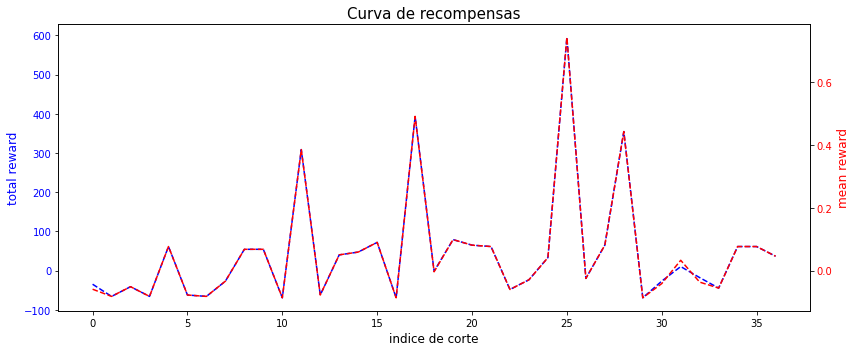

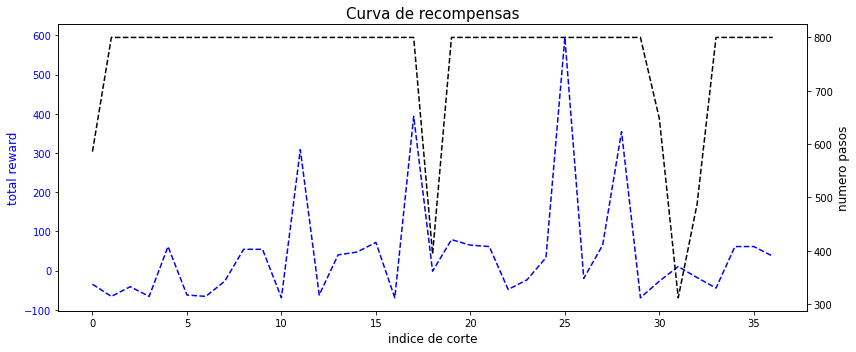

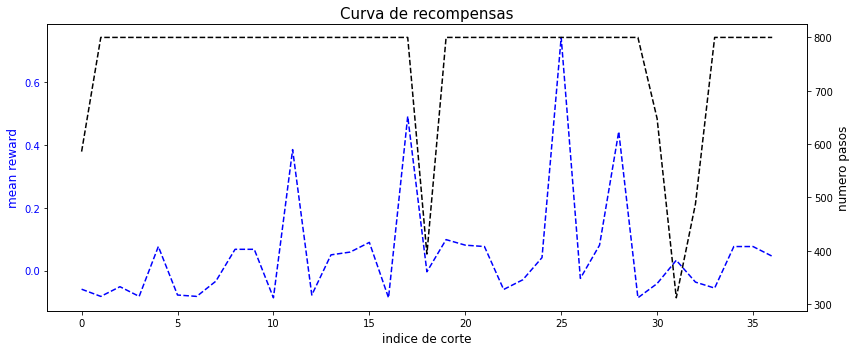

In [154]:
# [RESULTADOS] Ver graficas de curvas

def grafica_curvas(titulo,var_comun,titulox,var1,color1,titulo1,var2,color2,titulo2,figx=12,figy=5):

    fig, ax1 = plt.subplots(figsize=(figx,figy))
    ax1.plot(resultado_fit[var_comun],resultado_fit[var1], color1 + '--')
    ax1.set_ylabel(titulo1, color=color1,fontsize=12) 
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.set_xlabel(titulox,fontsize=12)

    ax2 = ax1.twinx()
    ax2.plot(resultado_fit[var_comun],resultado_fit[var2], color2 + '--')
    ax2.set_ylabel(titulo2, color=color2,fontsize=12)
    ax2.tick_params(axis='y', labelcolor=color2)

    plt.title(titulo,fontsize=15)
    fig.tight_layout() 
    plt.show()
    
grafica_curvas("Curva de recompensas","indice","indice de corte","rew_total","b","total reward","rew_mean","r","mean reward")
grafica_curvas("Curva de recompensas","indice","indice de corte","rew_total","b","total reward","num_pasos","k","numero pasos")
grafica_curvas("Curva de recompensas","indice","indice de corte","rew_mean","b","mean reward","num_pasos","k","numero pasos")

In [155]:
# "Mayor valor de reward total" (POSITIVO)
val_min = 0
resultado_fit[resultado_fit["rew_total"] > val_min].sort_values(["rew_total","num_pasos"],ascending=[False,True])

,indice,epoch,eps_train,eps_test,pasos_act,num_pasos,rew_mean,rew_total,archivo
25,25.0,2000.0,0.1400,0.1400,6.0,800.0,0.743640,594.911661,CarRacing_v7_4/wgt_2000.h5f
17,17.0,1360.0,0.1912,0.1912,6.0,800.0,0.491873,393.498233,CarRacing_v7_4/wgt_1360.h5f
28,28.0,2240.0,0.1208,0.1208,6.0,800.0,0.443286,354.628975,CarRacing_v7_4/wgt_2240.h5f
11,11.0,880.0,0.2296,0.2296,6.0,800.0,0.385866,308.692580,CarRacing_v7_4/wgt_880.h5f
19,19.0,1520.0,0.1784,0.1784,6.0,800.0,0.098763,79.010601,CarRacing_v7_4/wgt_1520.h5f
15,15.0,1200.0,0.2040,0.2040,6.0,800.0,0.089929,71.943463,CarRacing_v7_4/wgt_1200.h5f
27,27.0,2160.0,0.1272,0.1272,6.0,800.0,0.081095,64.876325,CarRacing_v7_4/wgt_2160.h5f
20,20.0,1600.0,0.1720,0.1720,6.0,800.0,0.081095,64.876325,CarRacing_v7_4/wgt_1600.h5f
34,34.0,2720.0,0.1000,0.1000,6.0,800.0,0.076678,61.342756,CarRacing_v7_4/wgt_2720.h5f
21,21.0,1680.0,0.1656,0.1656,6.0,800.0,0.076678,61.342756,CarRacing_v7_4/wgt_1680.h5f


In [94]:
# [SIMULACION DE TESTEO - FIJO] Evaluar rendimiento de agente/politica aprendida

indice_modelo = 27

########################

archivo_lee = resultado_fit.loc[indice_modelo,"archivo"]
print(pd.DataFrame(resultado_fit.loc[indice_modelo,:]))
print('Archivo leido:',archivo_lee)

# Asignar pesos a modelo
dqn_final = dqn
dqn_final.load_weights(archivo_lee)

visualiza_test(dqn_final,gym_evn=gym_env,n_pasos=2000,
               n_pasos_total=8000,
               eps_actua = 0.0,
               max_episodios=1,
               lap_percent=lap_percent,
               accion_adelanta = 3, # indicar valor para accion de "avanzar" - valor ya definidos
               accion_retrocede = 4, # indicar valor para accion de "retroceder" - valor ya definido
               n_pasos_limite_adelante = 22, # cantidad maxima de pasos "adelante" para aplicar medida de freno (retroceso)
               n_pasos_reinicia_otro = 12, # segun la cantidad de pasos seguidos "adelante" reinicia contrador "otro"
               n_pasos_reinicia_adelante = 5, # segun la cantidad de pasos seguidos "otro" reinicia contrador "adelante"
               random_color_envp = 0, # cambiar color de fondo aleatoriamente
               imprime=False)

                                                   27
indice                                           27.0
epoch                                          2160.0
eps_train                                       0.075
eps_test                                        0.075
pasos_act_repet                                   4.0
pasos_warmpup                                     3.0
num_pasos                                       800.0
rew_mean                                     0.072261
rew_total                                   57.809187
archivo          CarRacing_v7_4/wgt_trained2_2160.h5f
Archivo leido: CarRacing_v7_4/wgt_trained2_2160.h5f


In [ ]:
# [SIMULACION DE TESTEO - DINAMICO] Evaluar rendimiento de agente/politica aprendida

## Mejores modelo segun este testeo

indice_modelo = 27
seed_env_in = 47

########################

archivo_lee = resultado_fit.loc[indice_modelo,"archivo"]
print(pd.DataFrame(resultado_fit.loc[indice_modelo,:]))
print('Semilla de entorno:',seed_env_in)
print('Archivo leido:',archivo_lee)

# Asignar pesos a modelo
dqn_final = dqn
dqn_final.load_weights(archivo_lee)

visualiza_test(dqn_final,gym_evn=gym_env,n_pasos=700,
               n_pasos_total=8000,
               eps_actua = 0.0,
               max_episodios=1,
               lap_percent=lap_percent,
               accion_adelanta = 3, # indicar valor para accion de "avanzar" - valor ya definidos
               accion_retrocede = 4, # indicar valor para accion de "retroceder" - valor ya definido
               n_pasos_limite_adelante = 20, # cantidad maxima de pasos "adelante" para aplicar medida de freno (retroceso)
               n_pasos_reinicia_otro = 12, # segun la cantidad de pasos seguidos "adelante" reinicia contrador "otro"
               n_pasos_reinicia_adelante = 5, # segun la cantidad de pasos seguidos "otro" reinicia contrador "adelante"
               random_color_envp = 1, # cambiar color de fondo aleatoriamente
               seed_env = seed_env_in, # Indicar el color
               imprime=False)

In [297]:
# [ACTUALIZA MODELO - TRANSFIERE PESOS] Actualizar agente segun pesos de modelo entrenado

indice_modelo = 25

########################

archivo_lee = resultado_fit.loc[indice_modelo,"archivo"]
print(pd.DataFrame(resultado_fit.loc[indice_modelo,:]))
print('Archivo leido:',archivo_lee)

# Asignar pesos a modelo
dqn= dqn
dqn.load_weights(archivo_lee)

                                    25
indice                            25.0
epoch                           2000.0
eps_train                         0.14
eps_test                          0.14
pasos_act                          6.0
num_pasos                        800.0
rew_mean                       0.74364
rew_total                   594.911661
archivo    CarRacing_v7_4/wgt_2000.h5f
Archivo leido: CarRacing_v7_4/wgt_2000.h5f


In [ ]:
# [ADICIONAL - NO OBLIGATORIO] Ver capas 2D aprendidas (Conv2D)

try:
    capas = [capa for capa in dqn.model.layers]
    capas = [capa for capa in dqn.model.layers if "convolutional.conv2d" in str(capa)]
    capas = capas[::-1] # invertir el orden de capas
except:
    capas = [capa for capa in dqn_final.model.layers]
    capas = [capa for capa in dqn_final.model.layers if "convolutional.conv2d" in str(capa)]
    capas = capas[::-1] # invertir el orden de capas
    
for capa in capas:
    pesos, bias = capa.get_weights()
    
    try:
        n1, n2 = pesos.shape[0], pesos.shape[1]
        fig, axs = plt.subplots(n1,n2,figsize=(10,20))

        images = []
        for i in range(n1):
            for j in range(n2):
                print('Capa :',str(capa))
                imagen = pesos[i,j,:,:].copy()
                imagen = 255*(imagen - imagen.min(axis=0))/(imagen.max(axis=0) - imagen.min(axis=0)) # Escalar imagen
                images.append(axs[i, j].imshow(imagen)) # se puede colocar gris: cmap="gray"
                axs[i, j].label_outer()
        plt.show()
        
    except:
        pass

#### 2) Analizar resultados de Re-entrenamiento

In [29]:
# [VITAL!!] Indicar que tipo de resultados se va leer

lee_pesos_trained = 1

# 0 : leerá archivos que empiezan con "wgt_" 
# 1 : Leerá archivos que empiezan con "wgt_trainedM_"

print('Se indicó el valor:',lee_pesos_trained)

if(lee_pesos_trained):
    print("[1] : leerá archivos que empiezan con wgt_trained" + str(version_pesos_retrain) + "_")
    print('Version de pesos entrenados [version_pesos_retrain]:',version_pesos_retrain)
else:
    print("[0] : leerá archivos que empiezan con 'wgt_'")

Se indicó el valor: 1
[1] : leerá archivos que empiezan con wgt_trained_


In [25]:
# [CSV] Leer archivo csv con resultados

if(lee_pesos_trained):
    archivo_csv = carpeta + "resultado_trained" + str(version_pesos_retrain) + ".csv"
else:
    archivo_csv = carpeta + "resultado.csv"

print('Archivo:',archivo_csv)
resultado_fit = pd.read_csv(archivo_csv)
resultado_fit

Archivo: CarRacing_v7_4/resultado_trained.csv


,indice,epoch,eps_train,eps_test,pasos_act,num_pasos,rew_mean,rew_total,archivo
0,0.0,0.0,0.150000,0.150000,5.0,800.0,0.650883,520.706714,CarRacing_v7_4/wgt_trained_0.h5f
1,1.0,80.0,0.128873,0.128873,5.0,800.0,-0.064664,-51.731449,CarRacing_v7_4/wgt_trained_80.h5f
2,2.0,160.0,0.107534,0.107534,5.0,800.0,0.690636,552.508834,CarRacing_v7_4/wgt_trained_160.h5f
3,3.0,240.0,0.100000,0.100000,4.0,800.0,-0.055830,-44.664311,CarRacing_v7_4/wgt_trained_240.h5f
4,4.0,320.0,0.100000,0.100000,4.0,800.0,-0.007244,-5.795053,CarRacing_v7_4/wgt_trained_320.h5f
...,...,...,...,...,...,...,...,...,...
67,67.0,5360.0,0.100000,0.100000,4.0,800.0,-0.064664,-51.731449,CarRacing_v7_4/wgt_trained_5360.h5f
68,68.0,5440.0,0.100000,0.100000,4.0,800.0,0.059011,47.208481,CarRacing_v7_4/wgt_trained_5440.h5f
69,69.0,5520.0,0.100000,0.100000,4.0,800.0,0.076678,61.342756,CarRacing_v7_4/wgt_trained_5520.h5f
70,70.0,5600.0,0.100000,0.100000,4.0,606.0,-0.060767,-36.825088,CarRacing_v7_4/wgt_trained_5600.h5f


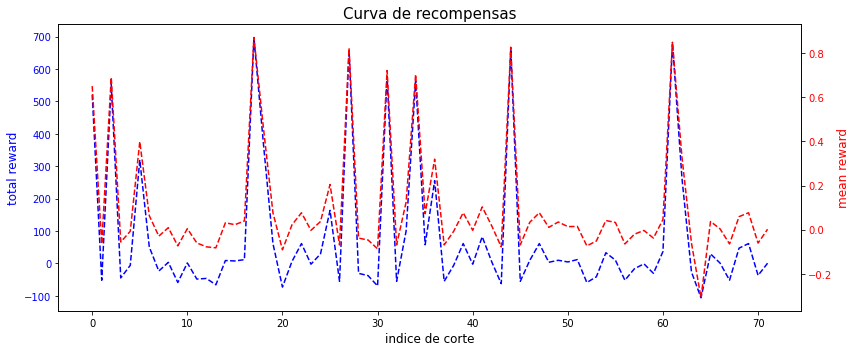

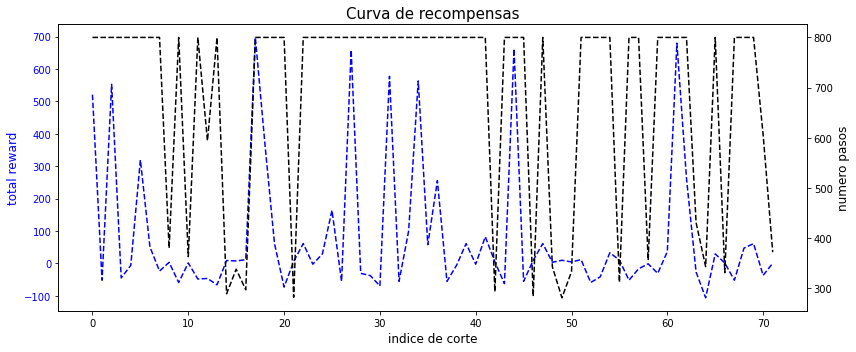

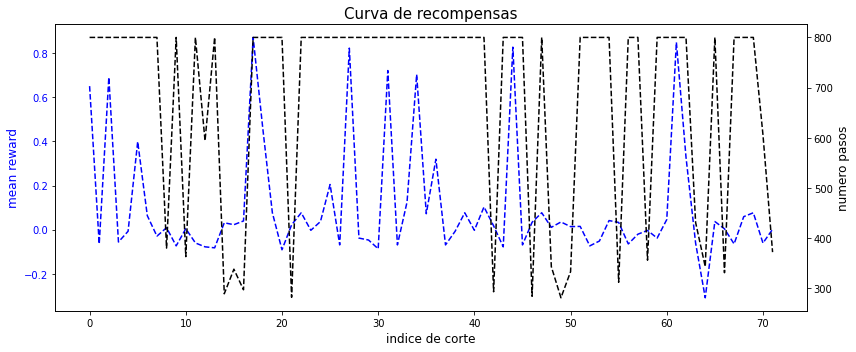

In [14]:
# [RESULTADOS] Ver graficas de curvas

def grafica_curvas(titulo,var_comun,titulox,var1,color1,titulo1,var2,color2,titulo2,figx=12,figy=5):

    fig, ax1 = plt.subplots(figsize=(figx,figy))
    ax1.plot(resultado_fit[var_comun],resultado_fit[var1], color1 + '--')
    ax1.set_ylabel(titulo1, color=color1,fontsize=12) 
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.set_xlabel(titulox,fontsize=12)

    ax2 = ax1.twinx()
    ax2.plot(resultado_fit[var_comun],resultado_fit[var2], color2 + '--')
    ax2.set_ylabel(titulo2, color=color2,fontsize=12)
    ax2.tick_params(axis='y', labelcolor=color2)

    plt.title(titulo,fontsize=15)
    fig.tight_layout() 
    plt.show()
    
grafica_curvas("Curva de recompensas","indice","indice de corte","rew_total","b","total reward","rew_mean","r","mean reward")
grafica_curvas("Curva de recompensas","indice","indice de corte","rew_total","b","total reward","num_pasos","k","numero pasos")
grafica_curvas("Curva de recompensas","indice","indice de corte","rew_mean","b","mean reward","num_pasos","k","numero pasos")

In [15]:
# "Mayor valor de reward total" (POSITIVO)
val_min = 0
resultado_fit[resultado_fit["rew_total"] > val_min].sort_values(["rew_total","num_pasos"],ascending=[False,True])

,indice,epoch,eps_train,eps_test,pasos_act,num_pasos,rew_mean,rew_total,archivo
17,17.0,1360.0,0.100000,0.100000,4.0,800.0,0.871731,697.385159,CarRacing_v7_4/wgt_trained_1360.h5f
61,61.0,4880.0,0.100000,0.100000,4.0,800.0,0.849647,679.717314,CarRacing_v7_4/wgt_trained_4880.h5f
44,44.0,3520.0,0.100000,0.100000,4.0,800.0,0.827562,662.049470,CarRacing_v7_4/wgt_trained_3520.h5f
27,27.0,2160.0,0.100000,0.100000,4.0,800.0,0.823145,658.515901,CarRacing_v7_4/wgt_trained_2160.h5f
31,31.0,2480.0,0.100000,0.100000,4.0,800.0,0.721555,577.243816,CarRacing_v7_4/wgt_trained_2480.h5f
34,34.0,2720.0,0.100000,0.100000,4.0,800.0,0.703887,563.109541,CarRacing_v7_4/wgt_trained_2720.h5f
2,2.0,160.0,0.107534,0.107534,5.0,800.0,0.690636,552.508834,CarRacing_v7_4/wgt_trained_160.h5f
0,0.0,0.0,0.150000,0.150000,5.0,800.0,0.650883,520.706714,CarRacing_v7_4/wgt_trained_0.h5f
18,18.0,1440.0,0.100000,0.100000,4.0,800.0,0.460954,368.763251,CarRacing_v7_4/wgt_trained_1440.h5f
5,5.0,400.0,0.100000,0.100000,4.0,800.0,0.399117,319.293286,CarRacing_v7_4/wgt_trained_400.h5f


In [94]:
# [SIMULACION DE TESTEO - FIJO] Evaluar rendimiento de agente/politica aprendida

indice_modelo = 27

########################

archivo_lee = resultado_fit.loc[indice_modelo,"archivo"]
print(pd.DataFrame(resultado_fit.loc[indice_modelo,:]))
print('Archivo leido:',archivo_lee)

# Asignar pesos a modelo
dqn_final = dqn
dqn_final.load_weights(archivo_lee)

visualiza_test(dqn_final,gym_evn=gym_env,n_pasos=2000,
               n_pasos_total=8000,
               eps_actua = 0.0,
               max_episodios=1,
               lap_percent=lap_percent,
               accion_adelanta = 3, # indicar valor para accion de "avanzar" - valor ya definidos
               accion_retrocede = 4, # indicar valor para accion de "retroceder" - valor ya definido
               n_pasos_limite_adelante = 22, # cantidad maxima de pasos "adelante" para aplicar medida de freno (retroceso)
               n_pasos_reinicia_otro = 12, # segun la cantidad de pasos seguidos "adelante" reinicia contrador "otro"
               n_pasos_reinicia_adelante = 5, # segun la cantidad de pasos seguidos "otro" reinicia contrador "adelante"
               random_color_envp = 0, # cambiar color de fondo aleatoriamente
               imprime=False)

                                                   27
indice                                           27.0
epoch                                          2160.0
eps_train                                       0.075
eps_test                                        0.075
pasos_act_repet                                   4.0
pasos_warmpup                                     3.0
num_pasos                                       800.0
rew_mean                                     0.072261
rew_total                                   57.809187
archivo          CarRacing_v7_4/wgt_trained2_2160.h5f
Archivo leido: CarRacing_v7_4/wgt_trained2_2160.h5f


In [ ]:
# [SIMULACION DE TESTEO - DINAMICO] Evaluar rendimiento de agente/politica aprendida

## Mejores modelo segun este testeo

indice_modelo = 27
seed_env_in = 47

########################

archivo_lee = resultado_fit.loc[indice_modelo,"archivo"]
print(pd.DataFrame(resultado_fit.loc[indice_modelo,:]))
print('Semilla de entorno:',seed_env_in)
print('Archivo leido:',archivo_lee)

# Asignar pesos a modelo
dqn_final = dqn
dqn_final.load_weights(archivo_lee)

visualiza_test(dqn_final,gym_evn=gym_env,n_pasos=700,
               n_pasos_total=8000,
               eps_actua = 0.0,
               max_episodios=1,
               lap_percent=lap_percent,
               accion_adelanta = 3, # indicar valor para accion de "avanzar" - valor ya definidos
               accion_retrocede = 4, # indicar valor para accion de "retroceder" - valor ya definido
               n_pasos_limite_adelante = 20, # cantidad maxima de pasos "adelante" para aplicar medida de freno (retroceso)
               n_pasos_reinicia_otro = 12, # segun la cantidad de pasos seguidos "adelante" reinicia contrador "otro"
               n_pasos_reinicia_adelante = 5, # segun la cantidad de pasos seguidos "otro" reinicia contrador "adelante"
               random_color_envp = 1, # cambiar color de fondo aleatoriamente
               seed_env = seed_env_in, # Indicar el color
               imprime=False)

In [318]:
# [ACTUALIZA MODELO - TRANSFIERE PESOS] Actualizar agente segun pesos de modelo entrenado

indice_modelo = 27

########################

archivo_lee = resultado_fit.loc[indice_modelo,"archivo"]
print(pd.DataFrame(resultado_fit.loc[indice_modelo,:]))
print('Archivo leido:',archivo_lee)

# Asignar pesos a modelo
dqn= dqn
dqn.load_weights(archivo_lee)

                                            27
indice                                    27.0
epoch                                   2160.0
eps_train                                  0.1
eps_test                                   0.1
pasos_act                                  4.0
num_pasos                                800.0
rew_mean                              0.823145
rew_total                           658.515901
archivo    CarRacing_v7_4/wgt_trained_2160.h5f
Archivo leido: CarRacing_v7_4/wgt_trained_2160.h5f


In [ ]:
# [ADICIONAL - NO OBLIGATORIO] Ver capas 2D aprendidas (Conv2D)

try:
    capas = [capa for capa in dqn.model.layers]
    capas = [capa for capa in dqn.model.layers if "convolutional.conv2d" in str(capa)]
    capas = capas[::-1] # invertir el orden de capas
except:
    capas = [capa for capa in dqn_final.model.layers]
    capas = [capa for capa in dqn_final.model.layers if "convolutional.conv2d" in str(capa)]
    capas = capas[::-1] # invertir el orden de capas
    
for capa in capas:
    pesos, bias = capa.get_weights()
    
    try:
        n1, n2 = pesos.shape[0], pesos.shape[1]
        fig, axs = plt.subplots(n1,n2,figsize=(10,20))

        images = []
        for i in range(n1):
            for j in range(n2):
                print('Capa :',str(capa))
                imagen = pesos[i,j,:,:].copy()
                imagen = 255*(imagen - imagen.min(axis=0))/(imagen.max(axis=0) - imagen.min(axis=0)) # Escalar imagen
                images.append(axs[i, j].imshow(imagen)) # se puede colocar gris: cmap="gray"
                axs[i, j].label_outer()
        plt.show()
        
    except:
        pass

El mejor de esta version es: **CarRacing_v7_4/wgt_trained_2160.h5f**

#### 3) [MEJOR MODELO] Analizar resultados de Re-entrenamiento

In [14]:
# [VITAL!!] Indicar que tipo de resultados se va leer

lee_pesos_trained = 1

# 0 : leerá archivos que empiezan con "wgt_" 
# 1 : Leerá archivos que empiezan con "wgt_trainedM_"

print('Se indicó el valor:',lee_pesos_trained)

if(lee_pesos_trained):
    print("[1] : leerá archivos que empiezan con wgt_trained" + str(version_pesos_retrain) + "_")
    print('Version de pesos entrenados [version_pesos_retrain]:',version_pesos_retrain)
else:
    print("[0] : leerá archivos que empiezan con 'wgt_'")

Se indicó el valor: 1
[1] : leerá archivos que empiezan con wgt_trained2_
Version de pesos entrenados [version_pesos_retrain]: 2


In [14]:
# [CSV] Leer archivo csv con resultados

if(lee_pesos_trained):
    archivo_csv = carpeta + "resultado_trained" + str(version_pesos_retrain) + ".csv"
else:
    archivo_csv = carpeta + "resultado.csv"

print('Archivo:',archivo_csv)
resultado_fit = pd.read_csv(archivo_csv)
resultado_fit

Archivo: CarRacing_v7_4/resultado_trained2.csv


,indice,epoch,eps_train,eps_test,pasos_act_repet,pasos_warmpup,num_pasos,rew_mean,rew_total,archivo
0,0.0,0.0,0.125000,0.125000,4.0,3.0,723.0,0.015969,11.545583,CarRacing_v7_4/wgt_trained2_0.h5f
1,1.0,80.0,0.094627,0.094627,4.0,3.0,800.0,-0.042580,-34.063604,CarRacing_v7_4/wgt_trained2_80.h5f
2,2.0,160.0,0.075000,0.075000,4.0,3.0,800.0,0.231272,185.017668,CarRacing_v7_4/wgt_trained2_160.h5f
3,3.0,240.0,0.075000,0.075000,4.0,3.0,800.0,-0.091166,-72.932862,CarRacing_v7_4/wgt_trained2_240.h5f
4,4.0,320.0,0.075000,0.075000,4.0,3.0,800.0,0.010424,8.339223,CarRacing_v7_4/wgt_trained2_320.h5f
...,...,...,...,...,...,...,...,...,...,...
81,81.0,6480.0,0.075000,0.075000,4.0,3.0,800.0,0.142933,114.346290,CarRacing_v7_4/wgt_trained2_6480.h5f
82,82.0,6560.0,0.075000,0.075000,4.0,3.0,800.0,0.041343,33.074205,CarRacing_v7_4/wgt_trained2_6560.h5f
83,83.0,6640.0,0.075000,0.075000,4.0,3.0,800.0,0.098763,79.010601,CarRacing_v7_4/wgt_trained2_6640.h5f
84,84.0,6720.0,0.075000,0.075000,4.0,3.0,800.0,0.059011,47.208481,CarRacing_v7_4/wgt_trained2_6720.h5f


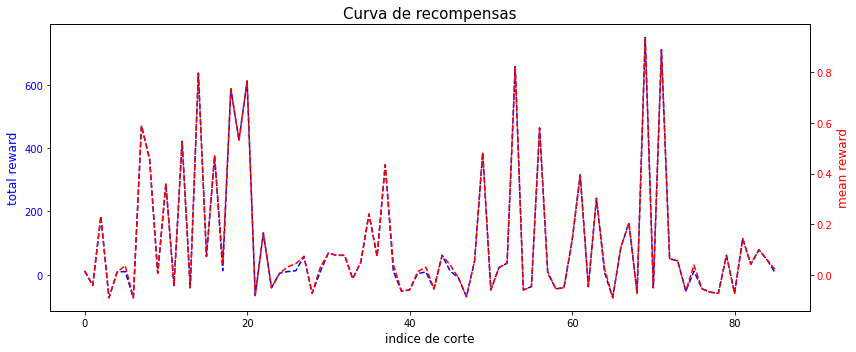

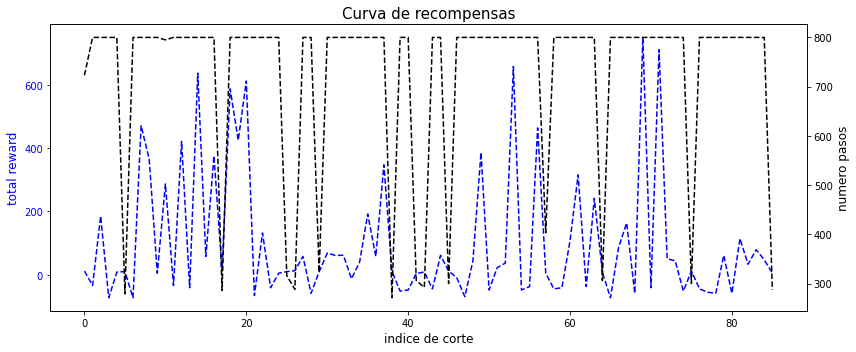

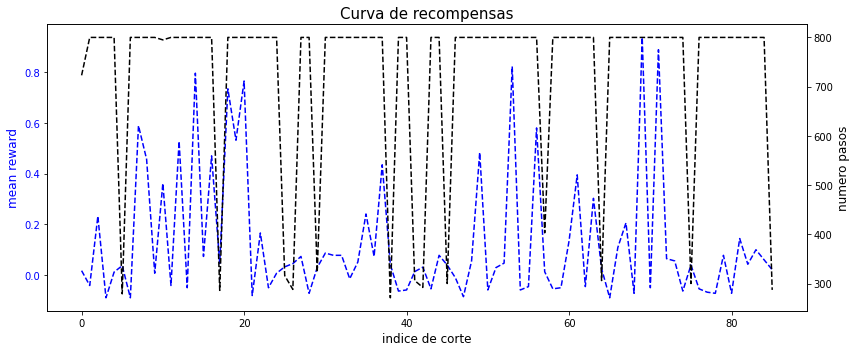

In [15]:
# [RESULTADOS] Ver graficas de curvas

def grafica_curvas(titulo,var_comun,titulox,var1,color1,titulo1,var2,color2,titulo2,figx=12,figy=5):

    fig, ax1 = plt.subplots(figsize=(figx,figy))
    ax1.plot(resultado_fit[var_comun],resultado_fit[var1], color1 + '--')
    ax1.set_ylabel(titulo1, color=color1,fontsize=12) 
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.set_xlabel(titulox,fontsize=12)

    ax2 = ax1.twinx()
    ax2.plot(resultado_fit[var_comun],resultado_fit[var2], color2 + '--')
    ax2.set_ylabel(titulo2, color=color2,fontsize=12)
    ax2.tick_params(axis='y', labelcolor=color2)

    plt.title(titulo,fontsize=15)
    fig.tight_layout() 
    plt.show()
    
grafica_curvas("Curva de recompensas","indice","indice de corte","rew_total","b","total reward","rew_mean","r","mean reward")
grafica_curvas("Curva de recompensas","indice","indice de corte","rew_total","b","total reward","num_pasos","k","numero pasos")
grafica_curvas("Curva de recompensas","indice","indice de corte","rew_mean","b","mean reward","num_pasos","k","numero pasos")

In [16]:
# "Mayor valor de reward total" (POSITIVO)
val_min = 0
resultado_fit[resultado_fit["rew_total"] > val_min].sort_values(["rew_total","num_pasos"],ascending=[False,True])

,indice,epoch,eps_train,eps_test,pasos_act_repet,pasos_warmpup,num_pasos,rew_mean,rew_total,archivo
69,69.0,5520.0,0.075,0.075,4.0,3.0,800.0,0.937986,750.388693,CarRacing_v7_4/wgt_trained2_5520.h5f
71,71.0,5680.0,0.075,0.075,4.0,3.0,800.0,0.889399,711.519435,CarRacing_v7_4/wgt_trained2_5680.h5f
53,53.0,4240.0,0.075,0.075,4.0,3.0,800.0,0.823145,658.515901,CarRacing_v7_4/wgt_trained2_4240.h5f
14,14.0,1120.0,0.075,0.075,4.0,3.0,800.0,0.796643,637.314488,CarRacing_v7_4/wgt_trained2_1120.h5f
20,20.0,1600.0,0.075,0.075,4.0,3.0,800.0,0.765724,612.579505,CarRacing_v7_4/wgt_trained2_1600.h5f
18,18.0,1440.0,0.075,0.075,4.0,3.0,800.0,0.734806,587.844523,CarRacing_v7_4/wgt_trained2_1440.h5f
7,7.0,560.0,0.075,0.075,4.0,3.0,800.0,0.589046,471.236749,CarRacing_v7_4/wgt_trained2_560.h5f
56,56.0,4480.0,0.075,0.075,4.0,3.0,800.0,0.580212,464.169611,CarRacing_v7_4/wgt_trained2_4480.h5f
19,19.0,1520.0,0.075,0.075,4.0,3.0,800.0,0.531625,425.300353,CarRacing_v7_4/wgt_trained2_1520.h5f
12,12.0,960.0,0.075,0.075,4.0,3.0,800.0,0.527208,421.766784,CarRacing_v7_4/wgt_trained2_960.h5f


In [20]:
# [SIMULACION DE TESTEO - FIJO] Evaluar rendimiento de agente/politica aprendida

## Mejores modelo segun este testeo

indice_modelo = 69

########################

archivo_lee = resultado_fit.loc[indice_modelo,"archivo"]
print(pd.DataFrame(resultado_fit.loc[indice_modelo,:]))
print('Archivo leido:',archivo_lee)

# Asignar pesos a modelo
dqn_final = dqn
dqn_final.load_weights(archivo_lee)

visualiza_test(dqn_final,gym_evn=gym_env,n_pasos=2500,
               n_pasos_total=8000,
               eps_actua = 0.0,
               max_episodios=1,
               lap_percent=lap_percent,
               accion_adelanta = 3, # indicar valor para accion de "avanzar" - valor ya definidos
               accion_retrocede = 4, # indicar valor para accion de "retroceder" - valor ya definido
               n_pasos_limite_adelante = 22, # cantidad maxima de pasos "adelante" para aplicar medida de freno (retroceso)
               n_pasos_reinicia_otro = 12, # segun la cantidad de pasos seguidos "adelante" reinicia contrador "otro"
               n_pasos_reinicia_adelante = 5, # segun la cantidad de pasos seguidos "otro" reinicia contrador "adelante"
               random_color_envp = 0, # cambiar color de fondo aleatoriamente
               imprime=False)

                                                   69
indice                                           69.0
epoch                                          5520.0
eps_train                                       0.075
eps_test                                        0.075
pasos_act_repet                                   4.0
pasos_warmpup                                     3.0
num_pasos                                       800.0
rew_mean                                     0.937986
rew_total                                  750.388693
archivo          CarRacing_v7_4/wgt_trained2_5520.h5f
Archivo leido: CarRacing_v7_4/wgt_trained2_5520.h5f


In [21]:
# [SIMULACION DE TESTEO - DINAMICO] Evaluar rendimiento de agente/politica aprendida

## Mejores modelo segun este testeo

indice_modelo = 69
seed_env_in = 47

########################

archivo_lee = resultado_fit.loc[indice_modelo,"archivo"]
print(pd.DataFrame(resultado_fit.loc[indice_modelo,:]))
print('Semilla de entorno:',seed_env_in)
print('Archivo leido:',archivo_lee)

# Asignar pesos a modelo
dqn_final = dqn
dqn_final.load_weights(archivo_lee)

visualiza_test(dqn_final,gym_evn=gym_env,n_pasos=1600,
               n_pasos_total=8000,
               eps_actua = 0.0,
               max_episodios=1,
               lap_percent=lap_percent,
               accion_adelanta = 3, # indicar valor para accion de "avanzar" - valor ya definidos
               accion_retrocede = 4, # indicar valor para accion de "retroceder" - valor ya definido
               n_pasos_limite_adelante = 20, # cantidad maxima de pasos "adelante" para aplicar medida de freno (retroceso)
               n_pasos_reinicia_otro = 12, # segun la cantidad de pasos seguidos "adelante" reinicia contrador "otro"
               n_pasos_reinicia_adelante = 5, # segun la cantidad de pasos seguidos "otro" reinicia contrador "adelante"
               random_color_envp = 1, # cambiar color de fondo aleatoriamente
               seed_env = seed_env_in, # Indicar el color
               imprime=False)

                                                   69
indice                                           69.0
epoch                                          5520.0
eps_train                                       0.075
eps_test                                        0.075
pasos_act_repet                                   4.0
pasos_warmpup                                     3.0
num_pasos                                       800.0
rew_mean                                     0.937986
rew_total                                  750.388693
archivo          CarRacing_v7_4/wgt_trained2_5520.h5f
Semilla de entorno: 47
Archivo leido: CarRacing_v7_4/wgt_trained2_5520.h5f


In [19]:
# [ACTUALIZA MODELO - TRANSFIERE PESOS] Actualizar agente segun pesos de modelo entrenado

indice_modelo = 69

########################

archivo_lee = resultado_fit.loc[indice_modelo,"archivo"]
print(pd.DataFrame(resultado_fit.loc[indice_modelo,:]))
print('Archivo leido:',archivo_lee)

# Asignar pesos a modelo
dqn = dqn
dqn.load_weights(archivo_lee)

                                                   69
indice                                           69.0
epoch                                          5520.0
eps_train                                       0.075
eps_test                                        0.075
pasos_act_repet                                   4.0
pasos_warmpup                                     3.0
num_pasos                                       800.0
rew_mean                                     0.937986
rew_total                                  750.388693
archivo          CarRacing_v7_4/wgt_trained2_5520.h5f
Archivo leido: CarRacing_v7_4/wgt_trained2_5520.h5f


El mejor de esta version es: **CarRacing_v7_4/wgt_trained2_5520.h5f**

In [ ]:
# [ADICIONAL - NO OBLIGATORIO] Ver capas 2D aprendidas (Conv2D)

try:
    capas = [capa for capa in dqn.model.layers]
    capas = [capa for capa in dqn.model.layers if "convolutional.conv2d" in str(capa)]
    capas = capas[::-1] # invertir el orden de capas
except:
    capas = [capa for capa in dqn_final.model.layers]
    capas = [capa for capa in dqn_final.model.layers if "convolutional.conv2d" in str(capa)]
    capas = capas[::-1] # invertir el orden de capas
    
for capa in capas:
    pesos, bias = capa.get_weights()
    
    try:
        n1, n2 = pesos.shape[0], pesos.shape[1]
        fig, axs = plt.subplots(n1,n2,figsize=(10,20))

        images = []
        for i in range(n1):
            for j in range(n2):
                print('Capa :',str(capa))
                imagen = pesos[i,j,:,:].copy()
                imagen = 255*(imagen - imagen.min(axis=0))/(imagen.max(axis=0) - imagen.min(axis=0)) # Escalar imagen
                images.append(axs[i, j].imshow(imagen)) # se puede colocar gris: cmap="gray"
                axs[i, j].label_outer()
        plt.show()
        
    except:
        pass

___

### 2) Discreto (fondo aleatorio)

NOTA: Previamente se realizaron entrenamiento de diversas versiones y la que se muestra aqui es la final encontrada. Esto significa que los parametros que se usan aqui son los mejores que se logró obtener de las multiples pruebas.

In [22]:
# [INFO GENERAL] valores del bloque

nom_env = "CarRacing" # nombre del entorno de simulacion
ver_modelo = 8       # version del bloque de modelo
ver_itera = 1        # numero de iteracion para la "version de modelo" 

# Crear carpeta para guardar pesos (posterior)
carpeta = nom_env + "_v" + str(ver_modelo) + "_"+ str(ver_itera) + "/"

print('Nombre entorno:',nom_env)
print('Version de modelo:',ver_modelo)
print('Version de iteracion:',ver_itera)
print('Direccion carpeta pesos:',carpeta)

Nombre entorno: CarRacing
Version de modelo: 8
Version de iteracion: 1
Direccion carpeta pesos: CarRacing_v8_1/


In [23]:
# Identificacion de rendimiento segun "semillas de entorno"

env_bueno = [6,27,33,2,4,38]
env_medio = [28,16]
env_mal = [18,24,26]

print('Bueno:',env_bueno)
print('Medio:',env_medio)
print('Malo: ',env_mal)

Bueno: [6, 27, 33, 2, 4, 38]
Medio: [28, 16]
Malo:  [18, 24, 26]


In [24]:
# [OBLIGATORIO] Leer entorno de simulacion - Inicializar

gym_env = "CarRacing-v2"
max_episode_steps = 1000
lap_percent = 0.85
semilla_env = env_bueno
semilla_action = 42

# Cambiar aleatoriamente de color de pista
random_color_env = 1

# Devuelve valore(s) aleatorio(s) segun lista
def semilla(semillas=semilla_env,k=1):
    if(k == 1):
        return random.sample(semillas,1)[0]
    else:
        return random.sample(semillas,k)

# Inicializar ambiente
env = gym.make(gym_env, render_mode="rgb_array",continuous=False,
               lap_complete_percent=lap_percent,
               domain_randomize=random_color_env,
               max_episode_steps=max_episode_steps)

print('Escenario elegido de GymAI:',gym_env)
print('¿Colores aleatorios en ambiente?:',random_color_env)
print("Acciones del espacio:",env.action_space.n)
print('Semilla para entorno:',semilla_env)
print('Semilla para acciones:',semilla_action)
print('Maximos pasos por episodio:',max_episode_steps)
print('Porcentaje de vuelta [%]:',np.round(100.*lap_percent,2))

# Seteo de semilla inicio
env.action_space.seed(semilla_action)

if(random_color_env):
    observation = env.reset(seed=semilla(),options={"randomize": random_color_env})
else:
    observation = env.reset(seed=semilla(),options={"randomize": random_color_env})

# Cantidad de acciones
num_actions = env.action_space.n

Escenario elegido de GymAI: CarRacing-v2
¿Colores aleatorios en ambiente?: 1
Acciones del espacio: 5
Semilla para entorno: [6, 27, 33, 2, 4, 38]
Semilla para acciones: 42
Maximos pasos por episodio: 1000
Porcentaje de vuelta [%]: 85.0


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 96, 96, 3)         0         
                                                                 
 cropping2d (Cropping2D)     (None, 84, 96, 3)         0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


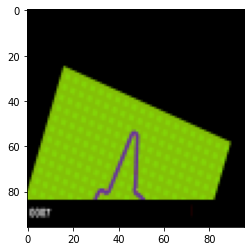

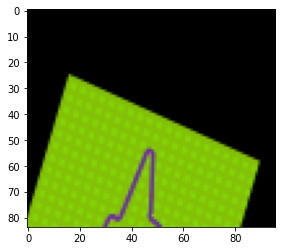

In [8]:
# [AUXILIAR - NO REQUERIDO] Validar recorte de imagen para eliminar margenes

# Se aplica la capa de recorte para reducir margenes no necesario de imagen

agent = Sequential()
agent.add(Reshape(env.observation_space.shape,input_shape=(1,) + env.observation_space.shape))
agent.add(Cropping2D(cropping=((0,12), (0,0))))
agent.summary()

##########################3

observationp, rewardp, terminatedp, _= env.step(env.action_space.sample())
plt.imshow(observationp)
plt.show()

observation = agent.predict(observationp[np.newaxis,np.newaxis,:,:])
plt.imshow(observation.astype("int")[0,:])
plt.show()

Los principales pasos para son:
- 1) Definir agente
- 2) Entrenamiento y validacion
- 3) Ver resultados
- 4) Ver modelo entrenado en aplicación

#### Opcion de modelos para el agente

In [25]:
# [MODELO] Definir e inicializar el agente de aprendizaje

# Es una alternativa donde se aplica recorte de imagen para eliminar los margenes

#####################################################
# [INFO] valores del bloque

nom_env = "CarRacing"           # nombre del entorno de simulacion
action_repetition_inicio = 6    # cantidad de pasos para el entrenamiento de agente
action_repetition_final = 3     # cantidad de pasos luego de haber entrenado # epochs

# Crear carpeta para guardar pesos (posterior)
carpeta = nom_env + "_v" + str(ver_modelo) + "_"+ str(ver_itera) + "/"

print('Nombre entorno:',nom_env)
print('Version de modelo:',ver_modelo)
print('Version de iteracion:',ver_itera)
print('Action repetition inicio:',action_repetition_inicio)
print('Action repetition final :',action_repetition_final)
print('Direccion carpeta pesos:',carpeta)
print('-----------------------------------------------\n')

#####################################################

agent = Sequential()
agent.add(Reshape(env.observation_space.shape,input_shape=(1,) + env.observation_space.shape))
agent.add(Cropping2D(cropping=((0,12), (0,0))))
agent.add(Rescaling(scale=1./255., offset=0.0)) 

agent.add(Conv2D(128, (3,3))) 
agent.add(Activation('relu'))
agent.add(MaxPooling2D(pool_size=(2, 2)))
agent.add(Dropout(0.2))

agent.add(Conv2D(128, (3,3)))
agent.add(Activation('relu'))
agent.add(MaxPooling2D(pool_size=(2, 2)))
agent.add(Dropout(0.2))

agent.add(Conv2D(64, (3,3)))
agent.add(Activation('relu'))
agent.add(MaxPooling2D(pool_size=(2, 2)))
agent.add(Dropout(0.1))

agent.add(Conv2D(64, (3,3)))
agent.add(Activation('relu'))
agent.add(MaxPooling2D(pool_size=(2, 2)))

agent.add(Conv2D(64,(3,3)))
agent.add(Activation('relu'))

agent.add(Flatten())

agent.add(Dense(16,activation="elu",
                kernel_regularizer=regularizers.L2(1e-4),
                bias_regularizer= regularizers.L2(1e-4)))

agent.add(Dense(num_actions,activation="linear",name="output"))

# ver modelo
agent.summary()

Nombre entorno: CarRacing
Version de modelo: 8
Version de iteracion: 1
Action repetition inicio: 6
Action repetition final : 3
Direccion carpeta pesos: CarRacing_v8_1/
-----------------------------------------------

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 96, 96, 3)         0         
                                                                 
 cropping2d_1 (Cropping2D)   (None, 84, 96, 3)         0         
                                                                 
 rescaling_1 (Rescaling)     (None, 84, 96, 3)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 82, 94, 128)       3584      
                                                                 
 activation_5 (Activation)   (None, 82, 94, 128)       0         
                                   

#### Entrenamiento y validacion

In [26]:
# [DEFINIR FUNCIONES] Definir funciones para evaluar y visualizar el modelo entrenado

# Definir funcion de visualizacion y evaluacion de modelo
def visualiza_test(dqnp,gym_evn= "CarRacing-v2",
                   eps_actua = 0.05,
                   n_pasos= 1300,
                   n_pasos_total= 5000,
                   max_episodios= 5,
                   lap_percent= 0.90,
                   seed_env= semilla(),
                   seed_action= semilla_action,
                   accion_adelanta = 3, # indicar valor para accion de "avanzar"
                   accion_retrocede = 4, # indicar valor para accion de "retroceder"
                   n_pasos_limite_adelante = 10, # cantidad maxima de pasos "adelante" para aplicar medida de freno (retroceso)
                   n_pasos_reinicia_otro = 10,  # segun la cantidad de pasos seguidos "adelante" reinicia contrador "otro"
                   n_pasos_reinicia_adelante = 4, # segun la cantidad de pasos seguidos "otro" reinicia contrador "adelante"
                   random_color_envp = 1,  # cambiar aleatoriamente el color de fondo
                   imprime= False):
    
    # Valor inicial de eps de "strategy" (para evitar modificar de forma irreversible)
    eps_inicial = dqnp.policy.eps
    
    # Para moverse aplicar eps_actua
    dqnp.policy.eps = eps_actua
    
    # crea entorno
    envp = gym.make(gym_env, render_mode="human",
                    continuous=False,
                    lap_complete_percent=lap_percent,
                    domain_randomize=random_color_envp,
                    max_episode_steps=n_pasos)
    
    # Seteo de semilla de inicio
    envp.action_space.seed(seed_action)
    
    if(random_color_envp):
        observationp = envp.reset(seed=seed_env,options={"randomize": random_color_envp})
    else:
        observationp = envp.reset(seed=seed_env,options={"randomize": random_color_envp})
    
    
    # seguimiento de recompensa
    suma_reward = 0
    episodios = 0
    
    #################
    ## Medidas de control para limitar velocidad
    
    # Registrar cuantas veces seguidas se aplica hacia "adelante"
    n_pasos_avanza_seguidos = 0
    
    # Registrar cuantas veces seguidas se aplica otra accion diferente de "adelante"
    n_pasos_no_avanza = 0
    #################
    
    
    # Recorrer los n_pasos
    for i in range(n_pasos_total):
        
        ### Prediccion de accion actual
        action_actual = dqnp.forward(observationp)
        
        
        #################################
        ## [COMPLEMENTO] Limitantes impuestas para evitar sobre-velocidad
        
        ## Esta aplicando accion hacia "adelante"
        if(action_actual == accion_adelanta):
            
            # Conteo de avance seguido
            n_pasos_avanza_seguidos += 1
            
            if(n_pasos_avanza_seguidos >= n_pasos_reinicia_otro):
                # Reinicia al contador de "otros"
                n_pasos_no_avanza = 0
            
        else:
            ### Esta aplicando una accion diferente a "adelante"
            n_pasos_no_avanza += 1
            
            if(n_pasos_no_avanza >= n_pasos_reinicia_adelante):
                # Reinicia al contador de "adelante"
                n_pasos_avanza_seguidos = 0
        
        # En caso se supere el limite aplicar estrategia de limitacion
        if(n_pasos_avanza_seguidos >= n_pasos_limite_adelante):
            
            # Indicar que la acccion a aplicar será de retroceso
            action_actual = accion_retrocede
            
            # reiniciar conteo de pasos
            n_pasos_avanza_seguidos = 0
            n_pasos_no_avanza = 0
        
        
        ################################
        ## Aplica accion y actualiza estados
        
        observationp, rewardp, terminatedp, _ = envp.step(action_actual)
        
        # Suma total de recompensas
        suma_reward += rewardp
        
        #################################
        
        ## Observado - Interaccion
        if(imprime):
            print('i:',i,';reward:',np.round(rewardp,2),';terminado:',terminatedp,' ; total reward:',np.round(rewardp,2))

        # En caso haya logrado alcanzar el objetivo se indica
        if terminatedp:
            
            # Reiniciar ambiente
            if(random_color_envp):
                observationp = envp.reset(seed=seed_env,options={"randomize": random_color_envp})
            else:
                observationp = envp.reset(seed=seed_env,options={"randomize": random_color_envp})

            # Calculo reward
            suma_reward = 0
            
            episodios +=1
            if(episodios >= max_episodios):
                break

    # Cerrar entorno
    envp.close()
    
    # Retornar a valor inicial de "eps"
    dqnp.policy.eps = eps_inicial


# Definir funcion de visualizacion y registro de metricas de rendimiento
def visualiza_test2(dqnp,gym_evn= "CarRacing-v2",
                    eps_actua= 0.05,
                    n_pasos= 1500,
                    max_episodios= 5,
                    lap_percent= 0.90,
                    seed_env= semilla(),
                    seed_action= semilla_action,
                    random_color_envp = 1,  # cambiar aleatoriamente el color de fondo
                    imprime= False):
    
    # Valor inicial de eps de "strategy" (para evitar modificar de forma irreversible)
    eps_inicial = dqnp.policy.eps
    
    # Para moverse aplicar eps_actua
    dqnp.policy.eps = eps_actua
    
    # crea entorno
    envp = gym.make(gym_env, render_mode="human",
                    continuous=False,
                    lap_complete_percent=lap_percent,
                    domain_randomize=random_color_envp,
                    max_episode_steps=n_pasos)
    
    # Seteo de semilla de inicio
    envp.action_space.seed(seed_action)
    
    # Reiniciar ambiente
    if(random_color_envp):
        observationp = envp.reset(seed=seed_env,options={"randomize": random_color_envp})
    else:
        observationp = envp.reset(seed=seed_env,options={"randomize": random_color_envp})
    
    # Reiniciar valores
    suma_reward = 0
    episodios = 0
    
    # cantidad de pasos en episodio actual
    episodio_ii = 0
    
    # Inicializar variables de rendimiento de episodio
    promedio_reward = None
    total_reward = None
    num_pasos = None
    
    # Recorrer los n_pasos
    for i in range(n_pasos):
        observationp, rewardp, terminatedp, _ = envp.step(dqnp.forward(observationp))
        
        # Suma total de recompensas
        suma_reward += rewardp
        
        # contador de pasos
        episodio_ii +=1

        ## Observado - Interaccion
        if(imprime):
            print('i:',i,';reward:',np.round(rewardp,2),';terminado:',terminatedp,' ; total reward:',np.round(rewardp,2))

        # En caso haya logrado alcanzar el objetivo se indica
        if terminatedp:
            
            # Calculo de valores del ultimo episodio finalizado
            promedio_reward = 1.*suma_reward/episodio_ii
            total_reward = 1.*suma_reward
            num_pasos = episodio_ii
            
            # Reiniciar ambiente
            if(random_color_envp):
                observationp = envp.reset(seed=seed_env,options={"randomize": random_color_envp})
            else:
                observationp = envp.reset(seed=seed_env,options={"randomize": random_color_envp})
            
            
            # Reiniciar valores
            suma_reward = 0
            episodio_ii = 0
            
            # cantidad de episodios terminados
            episodios +=1
            if(episodios >= max_episodios):
                # finaliza bucle for
                break

    # Cerrar entorno
    envp.close()
    
    # Retornar a valor inicial de "eps"
    dqnp.policy.eps = eps_inicial
    
    # retorna valores
    return [num_pasos,promedio_reward,total_reward]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 96, 96, 3)         0         
                                                                 
 cropping2d_1 (Cropping2D)   (None, 84, 96, 3)         0         
                                                                 
 rescaling_1 (Rescaling)     (None, 84, 96, 3)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 82, 94, 128)       3584      
                                                                 
 activation_5 (Activation)   (None, 82, 94, 128)       0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 41, 47, 128)      0         
 2D)                                                             
                                                      

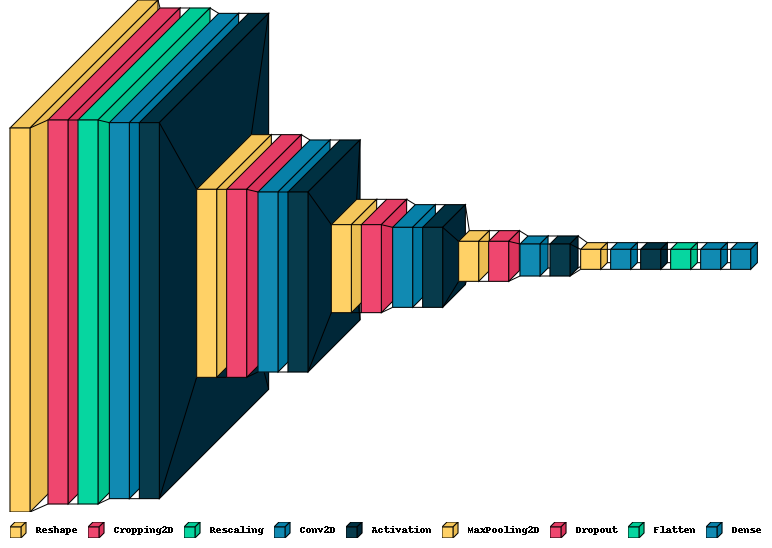

In [27]:
# [VISUALIZAR] Mostrar modelo de agente (DeepQ)
agent.summary()
visualkeras.layered_view(agent,legend=True)

**Entrenamiento de agente (DeepQ)**

In [28]:
# [NO ENTRENA - SOLO PARA TESTEO] Inicializar agente para testeo

##################################################################################
## NOTA: Tener mucho cuidado con la configuración de las 4 primeras variables ####
##################################################################################

# Indicar si se va entrenar o solo definir agente y parametros (util para testeo simulacion)
entrenar_agente = 0

####################
# En caso si se dese entrenar (entrenar == 1)

# Version de pesos a re-entrenar ("wgt_trainedM_") se añade la version "M" al nombre de archivo
version_pesos_retrain = "1"         # NOTA: A veces el inicio podria tener valor "" (vacio)

# [Tener cuidado!!!] borrar carpeta - en caso exista
borrar_carpeta = 0    # 0: No borra, 1: Borrar

# Indicar si se va inicializar el agente (En caso ya este cargado el agente quizas no se desee inicializar)
inicializar_agente = 1

# (1): Definir modelo inicial ("wgt_") / (0): Continuar entrenando modelo ("wgt_trainedM_")
entrenar_inicio = 0

##############################
# Borrado/Creacion de carpeta

print('Borrar carpeta en caso exista? [0:No, 1:Si]:',borrar_carpeta)
if(borrar_carpeta):
    try:
        shutil.rmtree(carpeta)
        print('[Informativo] Se pudo borrar carpeta ')
    except:
        print('[Informativo] No se pudo borrar carpeta')

# Crear carpeta para guardar pesos de modelos
os.makedirs(carpeta,exist_ok=True)
######################

# En cada training nuevo empezar el ambiente de forma aleatoria
env_inicio_aleatorio = 1

# Pasos maximos para testeo con modelo entrenado
n_pasos_test = 800

# Pasos de calentamiento en cada episodio (nb_steps_warmup)
n_pasos_warmup_inicio = 25
n_pasos_warmup_posterior = 3

# Cantidad de pasos seguidos a guardar (Memory_Limit)
memory_limit = 25

# Teclado a presionar para finalizar
teclado = "t"

# Informativo
print('Iniciar entrenamiento de agente o usar ya entrenado:',entrenar_inicio)

# IMPORTANTE, segun el valor de "entrenar_inicio"
## [0] : Se guardan los pesos en archivo "wtg_trained"
## [1] : Se guardan los pesos en archivo "wtg_"
## Se entiende que el "trained" es cuando se entrena un modelo previamente entrenado


# [INFORMATIVO] Nombre de carpeta y archivo
if(entrenar_inicio):
    print('Archivo a leer/escribir pesos de modelo:',carpeta + "wgt_EPOCH"  + ".h5f")
else:
    print('Archivo a leer/escribir pesos de modelo:',carpeta + "wgt_" + str(version_pesos_retrain)  + "_EPOCH"  + ".h5f")


#######################################################
#######################################################
## Definir e inicializar agente (DeepQ) ####

if(inicializar_agente):
    
    ### 1) Estrategia para determinar la accion del agente
    strategy = EpsGreedyQPolicy()
    #strategy = MaxBoltzmannQPolicy()
    

    ### 2) Memoria: cantidad de pasos a registrar
    memory = SequentialMemory(limit = memory_limit, window_length = 1)

    ### 3) Agente DeepQ
    dqn = DQNAgent(
        model = agent, 
        nb_actions = num_actions,
        memory = memory, 
        nb_steps_warmup = n_pasos_warmup_inicio,
        target_model_update = 2e-3,
        enable_double_dqn=False,
        enable_dueling_network=False,
        dueling_type = "max",
        policy = strategy
    )

    ### 4) Indicar compilador Tensorflow (Algoritmo iterativo de aprendizaje y metrica de evaluacion)
    lr = 2e-3
    dqn.compile(Adam(lr=lr), metrics =['mse'])
    print('[INFO] Se definió variable "dqn" con agente')

    
#######################################################
#######################################################
### Definir parametros de entrenamiento ###


if(entrenar_inicio): 
    ## A) INICIO ENTRENAMIENTO DE AGENTE (No entrenado previamente) ##
    
    ## Visualizar el entrenamiento inicial
    epochs_total = 40000 
    epochs_delta = 80   
    epochs_viz = 80      
    epochs_viz_actual = epochs_viz  # inicializar
    
    ## Parametros de epsilon para el entrenamiento
    eps_inicio = 0.40               
    eps_final  = 0.10               
    eps_ratio_decrece = 1./1000     
    dqn.policy.eps = eps_inicio
    
    # Inicializar el valor de repiticion de pasos por accion
    action_repetition = action_repetition_inicio
    
else:
    ## B) AGENTE YA ENTRENADO (Continuar entrenando) ##
    
    ## Ya se tiene modelo entrenado y se desea continuar
    epochs_total = 20000     
    epochs_delta = 80       
    epochs_viz = 80        
    epochs_viz_actual = epochs_viz  # inicializar
    
    ## Indicar la cantidad de pasos de calentamiento (np_step_warmup)
    dqn.nb_steps_warmup = n_pasos_warmup_posterior
    
    ## Parametros de epsilon para el entrenamiento
    eps_inicio = 0.175            
    eps_final  = 0.125          
    eps_ratio_decrece = 1./1500  
    dqn.policy.eps = eps_inicio   
    
    # Inicializar el valor de repiticion de pasos por accion -- NOTA: usar valor final
    action_repetition_inicio = 4
    action_repetition_final= action_repetition_inicio
    
    # actualizar valor actual
    action_repetition = action_repetition_inicio
    
    # Indicar learning rate del optimizador
    lr = 5e-5
    dqn.compile(Adam(lr=lr), metrics =['mse'])
    

#######################################################
#######################################################
### Entrenamiento ####

# Si se va entrenar
if(entrenar_agente):

    # Guardar valor de "eps"
    eps_ultimo = dqn.policy.eps

    # Seguimiento de modelos entrenados y registrados durante entrenamiento
    resultado_fit = pd.DataFrame()
    indice_fit = 0
    
    # Indicar el nombre del archivo de pesos del modelo "padre" previamente entrenado
    if(not entrenar_inicio):
        try:
            archivo_pesos_origen = archivo_lee
        except:
            archivo_pesos_origen = ""
    else:
        archivo_pesos_origen = ""

    ###########################
    

    ### [Principal] Bucle principal de entrenamiento
    for num_epoch in range(0,epochs_total,epochs_delta):

        # Colocar valor ultimo de "eps"
        dqn.policy.eps = eps_ultimo
        eps = eps_ultimo  # actualiza

        # Actualizar parametro pero no al inicio del bucle for, sino en la segunda iteracion
        if(num_epoch > 0):

            # parametro de pasos_warmup
            dqn.nb_steps_warmup = n_pasos_warmup_posterior


            ### Actualizar epsilon de busqueda aleatoria vs greedy
            ##eps = max(eps_final,eps*(eps_ratio_decrece**(epochs_delta/100.0)))  # No puede ser menor a "eps_final"
            eps = max(eps_final, (1.0*eps) - ((eps_ratio_decrece*epochs_delta)**2))  # No puede ser menor a "eps_final"
            dqn.policy.eps = eps


            # Condicion limite - actualizar cantidad de pasos por accion
            if(eps <= eps_final):    
                # Cambiar el numero de pasos de repiticion de accion
                action_repetition = action_repetition_final


        ##################

        # Informativo
        print('Valores :: de action_repetition:',action_repetition,' ; eps:',np.round(eps,6),' ; nb_steps_warmup:',dqn.nb_steps_warmup)

        # Entrenar modelo
        dqn.fit(env,nb_steps=epochs_delta, visualize = False, verbose=2, action_repetition=action_repetition)

        # Guardar ultimo valor de "eps"
        eps_ultimo = dqn.policy.eps

        ###################

        # finalizar ejecución - presione teclado
        if keyboard.is_pressed(teclado):
            break

        ###################

        # Visualizar segun entrenado - permite hacer seguimiento y entendimiento del aprendizaje del agente
        if(num_epoch + epochs_delta >= epochs_viz_actual):

            # borrar salida de consola (evitar saturar memoria)
            clear_output()

            ##################

            ### Testeo con agente entrenado ##
            eps_actua_test = eps_ultimo  # guarda ultimo valor de "eps"
            semilla_test = semilla(semillas=semilla_env,k=1)
            
            print('  -----  VISUALIZA ESTADO (EPOCH: ' + str(num_epoch + epochs_delta) + ' - SEED ENV:' + str(semilla_test) + ') ------- ')
            
            valores_reward = visualiza_test2(dqn,gym_evn=gym_env,
                                             n_pasos=n_pasos_test,
                                             eps_actua = eps_actua_test,
                                             max_episodios=1,
                                             seed_env= semilla_test,
                                             random_color_envp = random_color_env, # cambiar color de fondo aleatoriamente
                                             lap_percent=lap_percent)

            epochs_viz_actual += epochs_viz # actualiza el siguiente punto de testeo/visualizacion

            # Agregar resultados
            resultado_fit.loc[indice_fit,["indice","epoch","seed_test"]] = [indice_fit,num_epoch,semilla_test]
            resultado_fit.loc[indice_fit,["eps_train","eps_test","pasos_act_repet","pasos_warmpup"]] = [eps_ultimo,eps_actua_test,action_repetition,dqn.nb_steps_warmup]
            resultado_fit.loc[indice_fit,["num_pasos","rew_mean","rew_total"]] = valores_reward
            
            
            #################

            # Guardar pesos del modelo en archivo
            if(entrenar_inicio):
                archivo_pesos_modelo = carpeta + "wgt_" + str(num_epoch) + ".h5f"
            else:
                archivo_pesos_modelo = carpeta + "wgt_trained" + str(version_pesos_retrain) + "_" + str(num_epoch) + ".h5f"

            # guardar y actualizar
            dqn.save_weights(archivo_pesos_modelo, overwrite=True)
            resultado_fit.loc[indice_fit,"archivo"] = archivo_pesos_modelo
            resultado_fit.loc[indice_fit,"pesos_origen"] = archivo_pesos_origen  # archivo de pesos origen [trazabilidad]
            print('[INFO] Archivo pesos modelo entrenado:',archivo_pesos_modelo)
            indice_fit += 1  # aumenta cuenta de peso de modelos registrados (indice en dataframe resultante)
            
            #######################
            
            # Imprimir la tabla de los 5 mejores "total reward"
            print(resultado_fit.sort_values(["rew_total","num_pasos"],ascending=[False,True]).head(4))
            
            
        ###########################

        # Antes de volver a entrenar - reiniciar entorno de simulacion
        if(env_inicio_aleatorio):

            # Segun parametros inicializar el entorno
            env = gym.make(gym_env, render_mode="rgb_array",
                           continuous=False,
                           lap_complete_percent=lap_percent,
                           domain_randomize=random_color_env,
                           max_episode_steps=max_episode_steps)

            # Indicar semilla de aleatoriedad
            env.action_space.seed(semilla_action)
            
        #########################
        # Elegir aleatoriamente color de ambiente
        if(random_color_env):
            observation = env.reset(seed=semilla(semillas=semilla_env,k=1),options={"randomize": random_color_env})
        else:
            observation = env.reset(seed=semilla(semillas=semilla_env,k=1),options={"randomize": random_color_env})
        
        
else:
    print('No se va entrenar agente - solo se inicializó')


#######################################################
#######################################################
print('Finalizacion de entrenamiento')

Borrar carpeta en caso exista? [0:No, 1:Si]: 0
Iniciar entrenamiento de agente o usar ya entrenado: 0
Archivo a leer/escribir pesos de modelo: CarRacing_v8_1/wgt_1_EPOCH.h5f
[INFO] Se definió variable "dqn" con agente
No se va entrenar agente - solo se inicializó
Finalizacion de entrenamiento


In [ ]:
# [SOLO ENTRENAMIENTO] Crear modelo para encontrar la estrategia optima

##################################################################################
## NOTA: Tener mucho cuidado con la configuración de las 4 primeras variables ####
##################################################################################

# Indicar si se va entrenar o solo definir agente y parametros (util para testeo simulacion)
entrenar_agente = 1

####################
# En caso si se dese entrenar (entrenar == 1)

# Version de pesos a re-entrenar ("wgt_trainedM_") se añade la version "M" al nombre de archivo
version_pesos_retrain = "1"         # NOTA: A veces el inicio podria tener valor "" (vacio)

# [Tener cuidado!!!] borrar carpeta - en caso exista
borrar_carpeta = 0    # 0: No borra, 1: Borrar

# Indicar si se va inicializar el agente (En caso ya este cargado el agente quizas no se desee inicializar)
inicializar_agente = 1

# (1): Definir modelo inicial ("wgt_") / (0): Continuar entrenando modelo ("wgt_trainedM_")
entrenar_inicio = 0

###########################
# Borrado/Creacion de carpeta

print('Borrar carpeta en caso exista? [0:No, 1:Si]:',borrar_carpeta)
if(borrar_carpeta):
    try:
        shutil.rmtree(carpeta)
        print('[Informativo] Se pudo borrar carpeta ')
    except:
        print('[Informativo] No se pudo borrar carpeta')

# Crear carpeta para guardar pesos de modelos
os.makedirs(carpeta,exist_ok=True)
######################

# En cada training nuevo empezar el ambiente de forma aleatoria
env_inicio_aleatorio = 1

# Pasos maximos para testeo con modelo entrenado
n_pasos_test = 800

# Pasos de calentamiento en cada episodio (nb_steps_warmup)
n_pasos_warmup_inicio = 25
n_pasos_warmup_posterior = 3

# Cantidad de pasos seguidos a guardar (Memory_Limit)
memory_limit = 25

# Teclado a presionar para finalizar
teclado = "t"

# Informativo
print('Iniciar entrenamiento de agente o usar ya entrenado:',entrenar_inicio)

# IMPORTANTE, segun el valor de "entrenar_inicio"
## [0] : Se guardan los pesos en archivo "wtg_trained"
## [1] : Se guardan los pesos en archivo "wtg_"
## Se entiende que el "trained" es cuando se entrena un modelo previamente entrenado


# [INFORMATIVO] Nombre de carpeta y archivo
if(entrenar_inicio):
    print('Archivo a leer/escribir pesos de modelo:',carpeta + "wgt_EPOCH"  + ".h5f")
else:
    print('Archivo a leer/escribir pesos de modelo:',carpeta + "wgt_" + str(version_pesos_retrain)  + "_EPOCH"  + ".h5f")
    
#######################################################
#######################################################
## Definir e inicializar agente (DeepQ) ####

if(inicializar_agente):
    
    ### 1) Estrategia para determinar la accion del agente
    strategy = EpsGreedyQPolicy()
    #strategy = MaxBoltzmannQPolicy()
    

    ### 2) Memoria: cantidad de pasos a registrar
    memory = SequentialMemory(limit = memory_limit, window_length = 1)

    ### 3) Agente DeepQ
    dqn = DQNAgent(
        model = agent, 
        nb_actions = num_actions,
        memory = memory, 
        nb_steps_warmup = n_pasos_warmup_inicio,
        target_model_update = 2e-3,
        enable_double_dqn=False,
        enable_dueling_network=False,
        dueling_type = "max",
        policy = strategy
    )

    ### 4) Indicar compilador Tensorflow (Algoritmo iterativo de aprendizaje y metrica de evaluacion)
    lr = 2e-3
    dqn.compile(Adam(lr=lr), metrics =['mse'])
    print('[INFO] Se definió variable "dqn" con agente')

    
#######################################################
#######################################################
### Definir parametros de entrenamiento ###


if(entrenar_inicio): 
    ## A) INICIO ENTRENAMIENTO DE AGENTE (No entrenado previamente) ##
    
    ## Visualizar el entrenamiento inicial
    epochs_total = 40000 
    epochs_delta = 80   
    epochs_viz = 80      
    epochs_viz_actual = epochs_viz  # inicializar
    
    ## Parametros de epsilon para el entrenamiento
    eps_inicio = 0.40               
    eps_final  = 0.10               
    eps_ratio_decrece = 1./1000     
    dqn.policy.eps = eps_inicio
    
    # Inicializar el valor de repiticion de pasos por accion
    action_repetition = action_repetition_inicio
    
else:
    ## B) AGENTE YA ENTRENADO (Continuar entrenando) ##
    
    ## Ya se tiene modelo entrenado y se desea continuar
    epochs_total = 20000     
    epochs_delta = 80       
    epochs_viz = 80        
    epochs_viz_actual = epochs_viz  # inicializar
    
    ## Indicar la cantidad de pasos de calentamiento (np_step_warmup)
    dqn.nb_steps_warmup = n_pasos_warmup_posterior
    
    ## Parametros de epsilon para el entrenamiento
    eps_inicio = 0.175            
    eps_final  = 0.125          
    eps_ratio_decrece = 1./1500  
    dqn.policy.eps = eps_inicio   
    
    # Inicializar el valor de repiticion de pasos por accion -- NOTA: usar valor final
    action_repetition_inicio = 4
    action_repetition_final= action_repetition_inicio
    
    # actualizar valor actual
    action_repetition = action_repetition_inicio
    
    # Indicar learning rate del optimizador
    lr = 5e-5
    dqn.compile(Adam(lr=lr), metrics =['mse'])
    

#######################################################
#######################################################
### Entrenamiento ####

# Si se va entrenar
if(entrenar_agente):

    # Guardar valor de "eps"
    eps_ultimo = dqn.policy.eps

    # Seguimiento de modelos entrenados y registrados durante entrenamiento
    resultado_fit = pd.DataFrame()
    indice_fit = 0
    
    # Indicar el nombre del archivo de pesos del modelo "padre" previamente entrenado
    if(not entrenar_inicio):
        try:
            archivo_pesos_origen = archivo_lee
        except:
            archivo_pesos_origen = ""
    else:
        archivo_pesos_origen = ""

    ###########################
    

    ### [Principal] Bucle principal de entrenamiento
    for num_epoch in range(0,epochs_total,epochs_delta):

        # Colocar valor ultimo de "eps"
        dqn.policy.eps = eps_ultimo
        eps = eps_ultimo  # actualiza

        # Actualizar parametro pero no al inicio del bucle for, sino en la segunda iteracion
        if(num_epoch > 0):

            # parametro de pasos_warmup
            dqn.nb_steps_warmup = n_pasos_warmup_posterior


            ### Actualizar epsilon de busqueda aleatoria vs greedy
            ##eps = max(eps_final,eps*(eps_ratio_decrece**(epochs_delta/100.0)))  # No puede ser menor a "eps_final"
            eps = max(eps_final, (1.0*eps) - ((eps_ratio_decrece*epochs_delta)**2))  # No puede ser menor a "eps_final"
            dqn.policy.eps = eps


            # Condicion limite - actualizar cantidad de pasos por accion
            if(eps <= eps_final):    
                # Cambiar el numero de pasos de repiticion de accion
                action_repetition = action_repetition_final


        ##################

        # Informativo
        print('Valores :: de action_repetition:',action_repetition,' ; eps:',np.round(eps,6),' ; nb_steps_warmup:',dqn.nb_steps_warmup)

        # Entrenar modelo
        dqn.fit(env,nb_steps=epochs_delta, visualize = False, verbose=2, action_repetition=action_repetition)

        # Guardar ultimo valor de "eps"
        eps_ultimo = dqn.policy.eps

        ###################

        # finalizar ejecución - presione teclado
        if keyboard.is_pressed(teclado):
            break

        ###################

        # Visualizar segun entrenado - permite hacer seguimiento y entendimiento del aprendizaje del agente
        if(num_epoch + epochs_delta >= epochs_viz_actual):

            # borrar salida de consola (evitar saturar memoria)
            clear_output()

            ##################

            ### Testeo con agente entrenado ##
            eps_actua_test = eps_ultimo  # guarda ultimo valor de "eps"
            semilla_test = semilla(semillas=semilla_env,k=1)
            
            print('  -----  VISUALIZA ESTADO (EPOCH: ' + str(num_epoch + epochs_delta) + ' - SEED ENV:' + str(semilla_test) + ') ------- ')
            
            valores_reward = visualiza_test2(dqn,gym_evn=gym_env,
                                             n_pasos=n_pasos_test,
                                             eps_actua = eps_actua_test,
                                             max_episodios=1,
                                             seed_env= semilla_test,
                                             random_color_envp = random_color_env, # cambiar color de fondo aleatoriamente
                                             lap_percent=lap_percent)

            epochs_viz_actual += epochs_viz # actualiza el siguiente punto de testeo/visualizacion

            # Agregar resultados
            resultado_fit.loc[indice_fit,["indice","epoch","seed_test"]] = [indice_fit,num_epoch,semilla_test]
            resultado_fit.loc[indice_fit,["eps_train","eps_test","pasos_act_repet","pasos_warmpup"]] = [eps_ultimo,eps_actua_test,action_repetition,dqn.nb_steps_warmup]
            resultado_fit.loc[indice_fit,["num_pasos","rew_mean","rew_total"]] = valores_reward
            
            
            #################

            # Guardar pesos del modelo en archivo
            if(entrenar_inicio):
                archivo_pesos_modelo = carpeta + "wgt_" + str(num_epoch) + ".h5f"
            else:
                archivo_pesos_modelo = carpeta + "wgt_trained" + str(version_pesos_retrain) + "_" + str(num_epoch) + ".h5f"

            # guardar y actualizar
            dqn.save_weights(archivo_pesos_modelo, overwrite=True)
            resultado_fit.loc[indice_fit,"archivo"] = archivo_pesos_modelo
            resultado_fit.loc[indice_fit,"pesos_origen"] = archivo_pesos_origen  # archivo de pesos origen [trazabilidad]
            print('[INFO] Archivo pesos modelo entrenado:',archivo_pesos_modelo)
            indice_fit += 1  # aumenta cuenta de peso de modelos registrados (indice en dataframe resultante)
            
            #######################
            
            # Imprimir la tabla de los 5 mejores "total reward"
            print(resultado_fit.sort_values(["rew_total","num_pasos"],ascending=[False,True]).head(4))
            
            
        ###########################

        # Antes de volver a entrenar - reiniciar entorno de simulacion
        if(env_inicio_aleatorio):

            # Segun parametros inicializar el entorno
            env = gym.make(gym_env, render_mode="rgb_array",
                           continuous=False,
                           lap_complete_percent=lap_percent,
                           domain_randomize=random_color_env,
                           max_episode_steps=max_episode_steps)

            # Indicar semilla de aleatoriedad
            env.action_space.seed(semilla_action)
            
        #########################
        # Elegir aleatoriamente color de ambiente
        if(random_color_env):
            observation = env.reset(seed=semilla(semillas=semilla_env,k=1),options={"randomize": random_color_env})
        else:
            observation = env.reset(seed=semilla(semillas=semilla_env,k=1),options={"randomize": random_color_env})
        
        
else:
    print('No se va entrenar agente - solo se inicializó')


#######################################################
#######################################################
print('Finalizacion de entrenamiento')

In [26]:
# ver resultados en dataframe
resultado_fit

,indice,epoch,seed_test,eps_train,eps_test,pasos_act_repet,pasos_warmpup,num_pasos,rew_mean,rew_total,archivo,pesos_origen
0,0.0,0.0,33.0,0.175000,0.175000,4.0,3.0,800.0,0.431046,344.836601,CarRacing_v8_1/wgt_trained1_0.h5f,CarRacing_v7_4/wgt_trained2_5520.h5f
1,1.0,80.0,6.0,0.173906,0.173906,4.0,3.0,800.0,0.603376,482.700965,CarRacing_v8_1/wgt_trained1_80.h5f,CarRacing_v7_4/wgt_trained2_5520.h5f
2,2.0,160.0,27.0,0.172800,0.172800,4.0,3.0,800.0,0.650000,520.000000,CarRacing_v8_1/wgt_trained1_160.h5f,CarRacing_v7_4/wgt_trained2_5520.h5f
3,3.0,240.0,47.0,0.171684,0.171684,4.0,3.0,800.0,0.488983,391.186441,CarRacing_v8_1/wgt_trained1_240.h5f,CarRacing_v7_4/wgt_trained2_5520.h5f
4,4.0,320.0,33.0,0.170556,0.170556,4.0,3.0,800.0,0.520915,416.732026,CarRacing_v8_1/wgt_trained1_320.h5f,CarRacing_v7_4/wgt_trained2_5520.h5f
...,...,...,...,...,...,...,...,...,...,...,...,...
137,137.0,10960.0,6.0,0.125000,0.125000,4.0,3.0,800.0,0.100965,80.771704,CarRacing_v8_1/wgt_trained1_10960.h5f,CarRacing_v7_4/wgt_trained2_5520.h5f
138,138.0,11040.0,33.0,0.125000,0.125000,4.0,3.0,800.0,-0.071405,-57.124183,CarRacing_v8_1/wgt_trained1_11040.h5f,CarRacing_v7_4/wgt_trained2_5520.h5f
139,139.0,11120.0,47.0,0.125000,0.125000,4.0,3.0,800.0,-0.078814,-63.050847,CarRacing_v8_1/wgt_trained1_11120.h5f,CarRacing_v7_4/wgt_trained2_5520.h5f
140,140.0,11200.0,33.0,0.125000,0.125000,4.0,3.0,800.0,-0.087745,-70.196078,CarRacing_v8_1/wgt_trained1_11200.h5f,CarRacing_v7_4/wgt_trained2_5520.h5f


#### Ver resultados y Guardar en CSV

In [29]:
# [VITAL!!] Indicar qeu tipo de resultados se va leer

lee_pesos_trained = 1

# 0 : leerá archivos que empiezan con "wgt_" 
# 1 : Leerá archivos que empiezan con "wgt_trainedM_"

print('Se indicó el valor:',lee_pesos_trained)

if(lee_pesos_trained):
    print("[1] : leerá archivos que empiezan con wgt_trained" + str(version_pesos_retrain) + "_")
else:
    print("[0] : leerá archivos que empiezan con 'wgt_'")

Se indicó el valor: 1
[1] : leerá archivos que empiezan con wgt_trained1_


In [28]:
# [CSV] Guardar archivo csv con resultados

if(lee_pesos_trained):
    archivo_csv = carpeta + "resultado_trained" + str(version_pesos_retrain) + ".csv"
else:
    archivo_csv = carpeta + "resultado.csv"

resultado_fit.to_csv(archivo_csv,index=False)
print('Archivo:',archivo_csv)

Archivo: CarRacing_v8_1/resultado_trained1.csv


In [30]:
# [CSV] Leer archivo csv con resultados

if(lee_pesos_trained):
    archivo_csv = carpeta + "resultado_trained" + str(version_pesos_retrain) + ".csv"
else:
    archivo_csv = carpeta + "resultado.csv"

print('Archivo:',archivo_csv)
resultado_fit = pd.read_csv(archivo_csv)
resultado_fit

Archivo: CarRacing_v8_1/resultado_trained1.csv


,indice,epoch,seed_test,eps_train,eps_test,pasos_act_repet,pasos_warmpup,num_pasos,rew_mean,rew_total,archivo,pesos_origen
0,0.0,0.0,33.0,0.175000,0.175000,4.0,3.0,800.0,0.431046,344.836601,CarRacing_v8_1/wgt_trained1_0.h5f,CarRacing_v7_4/wgt_trained2_5520.h5f
1,1.0,80.0,6.0,0.173906,0.173906,4.0,3.0,800.0,0.603376,482.700965,CarRacing_v8_1/wgt_trained1_80.h5f,CarRacing_v7_4/wgt_trained2_5520.h5f
2,2.0,160.0,27.0,0.172800,0.172800,4.0,3.0,800.0,0.650000,520.000000,CarRacing_v8_1/wgt_trained1_160.h5f,CarRacing_v7_4/wgt_trained2_5520.h5f
3,3.0,240.0,47.0,0.171684,0.171684,4.0,3.0,800.0,0.488983,391.186441,CarRacing_v8_1/wgt_trained1_240.h5f,CarRacing_v7_4/wgt_trained2_5520.h5f
4,4.0,320.0,33.0,0.170556,0.170556,4.0,3.0,800.0,0.520915,416.732026,CarRacing_v8_1/wgt_trained1_320.h5f,CarRacing_v7_4/wgt_trained2_5520.h5f
...,...,...,...,...,...,...,...,...,...,...,...,...
137,137.0,10960.0,6.0,0.125000,0.125000,4.0,3.0,800.0,0.100965,80.771704,CarRacing_v8_1/wgt_trained1_10960.h5f,CarRacing_v7_4/wgt_trained2_5520.h5f
138,138.0,11040.0,33.0,0.125000,0.125000,4.0,3.0,800.0,-0.071405,-57.124183,CarRacing_v8_1/wgt_trained1_11040.h5f,CarRacing_v7_4/wgt_trained2_5520.h5f
139,139.0,11120.0,47.0,0.125000,0.125000,4.0,3.0,800.0,-0.078814,-63.050847,CarRacing_v8_1/wgt_trained1_11120.h5f,CarRacing_v7_4/wgt_trained2_5520.h5f
140,140.0,11200.0,33.0,0.125000,0.125000,4.0,3.0,800.0,-0.087745,-70.196078,CarRacing_v8_1/wgt_trained1_11200.h5f,CarRacing_v7_4/wgt_trained2_5520.h5f


#### 1) Analizar resultados - Inicio entrenamiento

In [ ]:
# [VITAL!!] Indicar que tipo de resultados se va leer

lee_pesos_trained = 0

# 0 : leerá archivos que empiezan con "wgt_" 
# 1 : Leerá archivos que empiezan con "wgt_trainedM_"

print('Se indicó el valor:',lee_pesos_trained)

if(lee_pesos_trained):
    print("[1] : leerá archivos que empiezan con wgt_trained" + str(version_pesos_retrain) + "_")
else:
    print("[0] : leerá archivos que empiezan con 'wgt_'")

In [ ]:
# [CSV] Leer archivo csv con resultados

if(lee_pesos_trained):
    archivo_csv = carpeta + "resultado_trained" + str(version_pesos_retrain) + ".csv"
else:
    archivo_csv = carpeta + "resultado.csv"

print('Archivo:',archivo_csv)
resultado_fit = pd.read_csv(archivo_csv)
resultado_fit

In [ ]:
# [RESULTADOS] Ver graficas de curvas

def grafica_curvas(titulo,var_comun,titulox,var1,color1,titulo1,var2,color2,titulo2,figx=12,figy=5):

    fig, ax1 = plt.subplots(figsize=(figx,figy))
    ax1.plot(resultado_fit[var_comun],resultado_fit[var1], color1 + '--')
    ax1.set_ylabel(titulo1, color=color1,fontsize=12) 
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.set_xlabel(titulox,fontsize=12)

    ax2 = ax1.twinx()
    ax2.plot(resultado_fit[var_comun],resultado_fit[var2], color2 + '--')
    ax2.set_ylabel(titulo2, color=color2,fontsize=12)
    ax2.tick_params(axis='y', labelcolor=color2)

    plt.title(titulo,fontsize=15)
    fig.tight_layout() 
    plt.show()
    
grafica_curvas("Curva de recompensas","indice","indice de corte","rew_total","b","total reward","rew_mean","r","mean reward")
grafica_curvas("Curva de recompensas","indice","indice de corte","rew_total","b","total reward","num_pasos","k","numero pasos")
grafica_curvas("Curva de recompensas","indice","indice de corte","rew_mean","b","mean reward","num_pasos","k","numero pasos")

In [ ]:
# "Mayor valor de reward total" (POSITIVO)
val_min = 0
resultado_fit[resultado_fit["rew_total"] > val_min].sort_values(["rew_total","num_pasos"],ascending=[False,True])

In [40]:
# Indicar indice de testo

indice_modelo = 75
print("Indice de modelo seleccionado:",indice_modelo)

Indice de modelo seleccionado: 75


In [51]:
# Cambiar lista de semilla de ambientes

semilla_env = env_medio
print('Semilla de ambiente:',semilla_env)

Semilla de ambiente: [2, 4, 28, 38, 16]


In [ ]:
# [SIMULACION DE TESTEO - FIJO] Evaluar rendimiento de agente/politica aprendida

archivo_lee = resultado_fit.loc[indice_modelo,"archivo"]
print(pd.DataFrame(resultado_fit.loc[indice_modelo,:]))
print('Archivo leido:',archivo_lee)

# Asignar pesos a modelo
dqn_final = dqn
dqn_final.load_weights(archivo_lee)

visualiza_test(dqn_final,gym_evn=gym_env,n_pasos=500,
               n_pasos_total=8000,
               eps_actua = 0.0,
               max_episodios=1,
               lap_percent=lap_percent,
               accion_adelanta = 3, # indicar valor para accion de "avanzar" - valor ya definidos
               accion_retrocede = 4, # indicar valor para accion de "retroceder" - valor ya definido
               n_pasos_limite_adelante = 22, # cantidad maxima de pasos "adelante" para aplicar medida de freno (retroceso)
               n_pasos_reinicia_otro = 12, # segun la cantidad de pasos seguidos "adelante" reinicia contrador "otro"
               n_pasos_reinicia_adelante = 5, # segun la cantidad de pasos seguidos "otro" reinicia contrador "adelante"
               random_color_envp = 0, # cambiar color de fondo aleatoriamente
               imprime=False)

In [ ]:
# [SIMULACION DE TESTEO - DINAMICO] Evaluar rendimiento de agente/politica aprendida

semillav = semilla(semillas=semilla_env,k=1)
archivo_lee = resultado_fit.loc[indice_modelo,"archivo"]
print(pd.DataFrame(resultado_fit.loc[indice_modelo,:]))
print('Archivo leido:',archivo_lee)
print('Semilla entorno:',semillav)

# Asignar pesos a modelo
dqn_final = dqn
dqn_final.load_weights(archivo_lee)

visualiza_test(dqn_final,gym_evn=gym_env,n_pasos=1800,
               n_pasos_total=8000,
               eps_actua = 0.0,
               max_episodios=1,
               lap_percent=lap_percent,
               accion_adelanta = 3, # indicar valor para accion de "avanzar" - valor ya definidos
               accion_retrocede = 4, # indicar valor para accion de "retroceder" - valor ya definido
               n_pasos_limite_adelante = 22, # cantidad maxima de pasos "adelante" para aplicar medida de freno (retroceso)
               n_pasos_reinicia_otro = 12, # segun la cantidad de pasos seguidos "adelante" reinicia contrador "otro"
               n_pasos_reinicia_adelante = 5, # segun la cantidad de pasos seguidos "otro" reinicia contrador "adelante"
               random_color_envp = 1, # cambiar color de fondo aleatoriamente
               seed_env= semillav,
               imprime=False)

                                                   75
indice                                           75.0
epoch                                          6000.0
seed_test                                        27.0
eps_train                                       0.125
eps_test                                        0.125
pasos_act_repet                                   4.0
pasos_warmpup                                     3.0
num_pasos                                       800.0
rew_mean                                     0.843396
rew_total                                  674.716981
archivo          CarRacing_v8_1/wgt_trained1_6000.h5f
pesos_origen     CarRacing_v7_4/wgt_trained2_5520.h5f
Archivo leido: CarRacing_v8_1/wgt_trained1_6000.h5f
Semilla entorno: 38


In [ ]:
# [ACTUALIZA MODELO - TRANSFIERE PESOS] Actualizar agente segun pesos de modelo entrenado

indice_modelo = 25

########################

archivo_lee = resultado_fit.loc[indice_modelo,"archivo"]
print(pd.DataFrame(resultado_fit.loc[indice_modelo,:]))
print('Archivo leido:',archivo_lee)

# Asignar pesos a modelo
dqn= dqn
dqn.load_weights(archivo_lee)

In [ ]:
# [ADICIONAL - NO OBLIGATORIO] Ver capas 2D aprendidas (Conv2D)

try:
    capas = [capa for capa in dqn.model.layers]
    capas = [capa for capa in dqn.model.layers if "convolutional.conv2d" in str(capa)]
    capas = capas[::-1] # invertir el orden de capas
except:
    capas = [capa for capa in dqn_final.model.layers]
    capas = [capa for capa in dqn_final.model.layers if "convolutional.conv2d" in str(capa)]
    capas = capas[::-1] # invertir el orden de capas
    
for capa in capas:
    pesos, bias = capa.get_weights()
    
    try:
        n1, n2 = pesos.shape[0], pesos.shape[1]
        fig, axs = plt.subplots(n1,n2,figsize=(10,20))

        images = []
        for i in range(n1):
            for j in range(n2):
                print('Capa :',str(capa))
                imagen = pesos[i,j,:,:].copy()
                imagen = 255*(imagen - imagen.min(axis=0))/(imagen.max(axis=0) - imagen.min(axis=0)) # Escalar imagen
                images.append(axs[i, j].imshow(imagen)) # se puede colocar gris: cmap="gray"
                axs[i, j].label_outer()
        plt.show()
        
    except:
        pass

#### 2) Analizar resultados de Re-entrenamiento

In [30]:
# [VITAL!!] Indicar que tipo de resultados se va leer

lee_pesos_trained = 1

# 0 : leerá archivos que empiezan con "wgt_" 
# 1 : Leerá archivos que empiezan con "wgt_trainedM_"

print('Se indicó el valor:',lee_pesos_trained)

if(lee_pesos_trained):
    print("[1] : leerá archivos que empiezan con wgt_trained" + str(version_pesos_retrain) + "_")
    print('Version de pesos entrenados [version_pesos_retrain]:',version_pesos_retrain)
else:
    print("[0] : leerá archivos que empiezan con 'wgt_'")

Se indicó el valor: 1
[1] : leerá archivos que empiezan con wgt_trained1_


In [31]:
# [CSV] Leer archivo csv con resultados

if(lee_pesos_trained):
    archivo_csv = carpeta + "resultado_trained" + str(version_pesos_retrain) + ".csv"
else:
    archivo_csv = carpeta + "resultado.csv"

print('Archivo:',archivo_csv)
resultado_fit = pd.read_csv(archivo_csv)
resultado_fit

Archivo: CarRacing_v8_1/resultado_trained1.csv


,indice,epoch,seed_test,eps_train,eps_test,pasos_act_repet,pasos_warmpup,num_pasos,rew_mean,rew_total,archivo,pesos_origen
0,0.0,0.0,33.0,0.175000,0.175000,4.0,3.0,800.0,0.431046,344.836601,CarRacing_v8_1/wgt_trained1_0.h5f,CarRacing_v7_4/wgt_trained2_5520.h5f
1,1.0,80.0,6.0,0.173906,0.173906,4.0,3.0,800.0,0.603376,482.700965,CarRacing_v8_1/wgt_trained1_80.h5f,CarRacing_v7_4/wgt_trained2_5520.h5f
2,2.0,160.0,27.0,0.172800,0.172800,4.0,3.0,800.0,0.650000,520.000000,CarRacing_v8_1/wgt_trained1_160.h5f,CarRacing_v7_4/wgt_trained2_5520.h5f
3,3.0,240.0,47.0,0.171684,0.171684,4.0,3.0,800.0,0.488983,391.186441,CarRacing_v8_1/wgt_trained1_240.h5f,CarRacing_v7_4/wgt_trained2_5520.h5f
4,4.0,320.0,33.0,0.170556,0.170556,4.0,3.0,800.0,0.520915,416.732026,CarRacing_v8_1/wgt_trained1_320.h5f,CarRacing_v7_4/wgt_trained2_5520.h5f
...,...,...,...,...,...,...,...,...,...,...,...,...
137,137.0,10960.0,6.0,0.125000,0.125000,4.0,3.0,800.0,0.100965,80.771704,CarRacing_v8_1/wgt_trained1_10960.h5f,CarRacing_v7_4/wgt_trained2_5520.h5f
138,138.0,11040.0,33.0,0.125000,0.125000,4.0,3.0,800.0,-0.071405,-57.124183,CarRacing_v8_1/wgt_trained1_11040.h5f,CarRacing_v7_4/wgt_trained2_5520.h5f
139,139.0,11120.0,47.0,0.125000,0.125000,4.0,3.0,800.0,-0.078814,-63.050847,CarRacing_v8_1/wgt_trained1_11120.h5f,CarRacing_v7_4/wgt_trained2_5520.h5f
140,140.0,11200.0,33.0,0.125000,0.125000,4.0,3.0,800.0,-0.087745,-70.196078,CarRacing_v8_1/wgt_trained1_11200.h5f,CarRacing_v7_4/wgt_trained2_5520.h5f


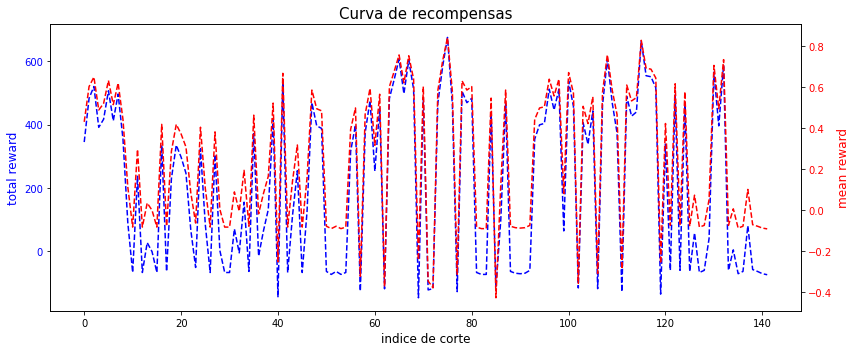

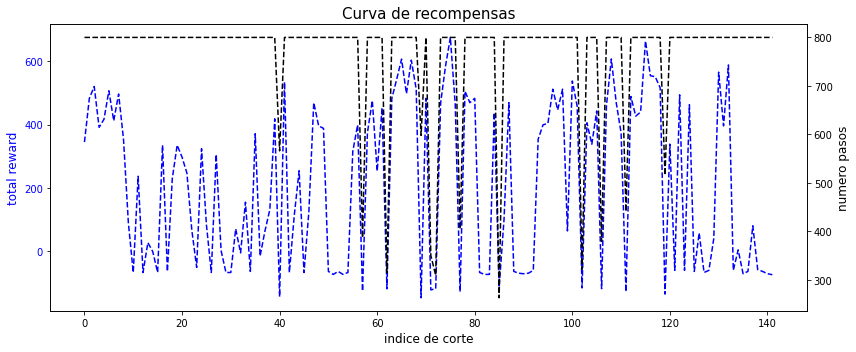

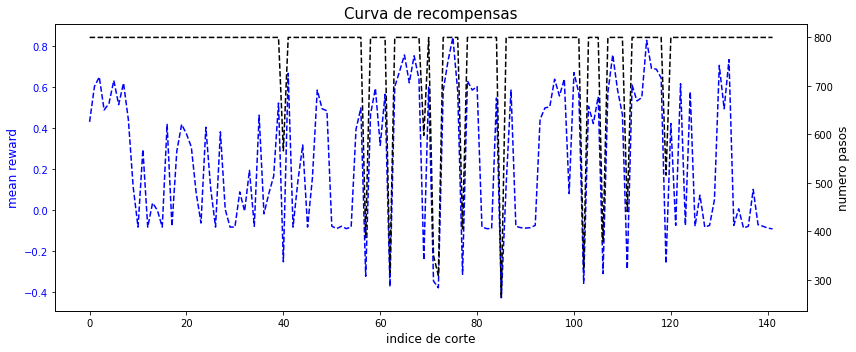

In [32]:
# [RESULTADOS] Ver graficas de curvas

def grafica_curvas(titulo,var_comun,titulox,var1,color1,titulo1,var2,color2,titulo2,figx=12,figy=5):

    fig, ax1 = plt.subplots(figsize=(figx,figy))
    ax1.plot(resultado_fit[var_comun],resultado_fit[var1], color1 + '--')
    ax1.set_ylabel(titulo1, color=color1,fontsize=12) 
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.set_xlabel(titulox,fontsize=12)

    ax2 = ax1.twinx()
    ax2.plot(resultado_fit[var_comun],resultado_fit[var2], color2 + '--')
    ax2.set_ylabel(titulo2, color=color2,fontsize=12)
    ax2.tick_params(axis='y', labelcolor=color2)

    plt.title(titulo,fontsize=15)
    fig.tight_layout() 
    plt.show()
    
grafica_curvas("Curva de recompensas","indice","indice de corte","rew_total","b","total reward","rew_mean","r","mean reward")
grafica_curvas("Curva de recompensas","indice","indice de corte","rew_total","b","total reward","num_pasos","k","numero pasos")
grafica_curvas("Curva de recompensas","indice","indice de corte","rew_mean","b","mean reward","num_pasos","k","numero pasos")

In [33]:
# "Mayor valor de reward total" (POSITIVO)
val_min = 0
resultado_fit[resultado_fit["rew_total"] > val_min].sort_values(["rew_total","num_pasos"],ascending=[False,True])

,indice,epoch,seed_test,eps_train,eps_test,pasos_act_repet,pasos_warmpup,num_pasos,rew_mean,rew_total,archivo,pesos_origen
75,75.0,6000.0,27.0,0.125000,0.125000,4.0,3.0,800.0,0.843396,674.716981,CarRacing_v8_1/wgt_trained1_6000.h5f,CarRacing_v7_4/wgt_trained2_5520.h5f
115,115.0,9200.0,27.0,0.125000,0.125000,4.0,3.0,800.0,0.829245,663.396226,CarRacing_v8_1/wgt_trained1_9200.h5f,CarRacing_v7_4/wgt_trained2_5520.h5f
108,108.0,8640.0,27.0,0.125000,0.125000,4.0,3.0,800.0,0.758491,606.792453,CarRacing_v8_1/wgt_trained1_8640.h5f,CarRacing_v7_4/wgt_trained2_5520.h5f
65,65.0,5200.0,33.0,0.125000,0.125000,4.0,3.0,800.0,0.757843,606.274510,CarRacing_v8_1/wgt_trained1_5200.h5f,CarRacing_v7_4/wgt_trained2_5520.h5f
67,67.0,5360.0,27.0,0.125000,0.125000,4.0,3.0,800.0,0.753774,603.018868,CarRacing_v8_1/wgt_trained1_5360.h5f,CarRacing_v7_4/wgt_trained2_5520.h5f
...,...,...,...,...,...,...,...,...,...,...,...,...
126,126.0,10080.0,6.0,0.125000,0.125000,4.0,3.0,800.0,0.072830,58.263666,CarRacing_v8_1/wgt_trained1_10080.h5f,CarRacing_v7_4/wgt_trained2_5520.h5f
129,129.0,10320.0,33.0,0.125000,0.125000,4.0,3.0,800.0,0.051144,40.915033,CarRacing_v8_1/wgt_trained1_10320.h5f,CarRacing_v7_4/wgt_trained2_5520.h5f
13,13.0,1040.0,33.0,0.159886,0.159886,4.0,3.0,800.0,0.034804,27.843137,CarRacing_v8_1/wgt_trained1_1040.h5f,CarRacing_v7_4/wgt_trained2_5520.h5f
134,134.0,10720.0,33.0,0.125000,0.125000,4.0,3.0,800.0,0.006209,4.967320,CarRacing_v8_1/wgt_trained1_10720.h5f,CarRacing_v7_4/wgt_trained2_5520.h5f


In [37]:
# Mejor ranking por cada ambiente

lista_env = resultado_fit["seed_test"].unique().tolist()
for valor_env in lista_env:
    print('-----------------------------------------------------')
    print('Semilla ambiente:',valor_env)
    
    print(resultado_fit[resultado_fit["seed_test"] == valor_env].
          sort_values(["rew_total","num_pasos"],ascending=[False,True]).head(4).loc[:,:"rew_total"])

-----------------------------------------------------
Semilla ambiente: 33.0
     indice   epoch  seed_test  eps_train  eps_test  pasos_act_repet  \
65     65.0  5200.0       33.0      0.125     0.125              4.0   
74     74.0  5920.0       33.0      0.125     0.125              4.0   
116   116.0  9280.0       33.0      0.125     0.125              4.0   
117   117.0  9360.0       33.0      0.125     0.125              4.0   

     pasos_warmpup  num_pasos  rew_mean   rew_total  
65             3.0      800.0  0.757843  606.274510  
74             3.0      800.0  0.729248  583.398693  
116            3.0      800.0  0.692484  553.986928  
117            3.0      800.0  0.688399  550.718954  
-----------------------------------------------------
Semilla ambiente: 6.0
     indice   epoch  seed_test  eps_train  eps_test  pasos_act_repet  \
100   100.0  8000.0        6.0   0.125000  0.125000              4.0   
98     98.0  7840.0        6.0   0.125000  0.125000              4.0   


In [80]:
# Indicar indice de testo

indice_modelo = 75
print("Indice de modelo seleccionado:",indice_modelo)

Indice de modelo seleccionado: 75


In [64]:
# Cambiar lista de semilla de ambientes

semilla_env = env_bueno
print('Semilla de ambiente:',semilla_env)

Semilla de ambiente: [6, 27, 33, 2, 4, 38]


In [ ]:
# [SIMULACION DE TESTEO - FIJO] Evaluar rendimiento de agente/politica aprendida

archivo_lee = resultado_fit.loc[indice_modelo,"archivo"]
print(pd.DataFrame(resultado_fit.loc[indice_modelo,:]))
print('Archivo leido:',archivo_lee)

# Asignar pesos a modelo
dqn_final = dqn
dqn_final.load_weights(archivo_lee)

visualiza_test(dqn_final,gym_evn=gym_env,n_pasos=500,
               n_pasos_total=8000,
               eps_actua = 0.0,
               max_episodios=1,
               lap_percent=lap_percent,
               accion_adelanta = 3, # indicar valor para accion de "avanzar" - valor ya definidos
               accion_retrocede = 4, # indicar valor para accion de "retroceder" - valor ya definido
               n_pasos_limite_adelante = 22, # cantidad maxima de pasos "adelante" para aplicar medida de freno (retroceso)
               n_pasos_reinicia_otro = 12, # segun la cantidad de pasos seguidos "adelante" reinicia contrador "otro"
               n_pasos_reinicia_adelante = 5, # segun la cantidad de pasos seguidos "otro" reinicia contrador "adelante"
               random_color_envp = 0, # cambiar color de fondo aleatoriamente
               imprime=False)

In [84]:
# [SIMULACION DE TESTEO - DINAMICO] Evaluar rendimiento de agente/politica aprendida

semillav = semilla(semillas=semilla_env,k=1)
archivo_lee = resultado_fit.loc[indice_modelo,"archivo"]
print(pd.DataFrame(resultado_fit.loc[indice_modelo,:]))
print('Archivo leido:',archivo_lee)
print('Semilla entorno:',semillav)

# Asignar pesos a modelo
dqn_final = dqn
dqn_final.load_weights(archivo_lee)

visualiza_test(dqn_final,gym_evn=gym_env,n_pasos=1800,
               n_pasos_total=8000,
               eps_actua = 0.0,
               max_episodios=1,
               lap_percent=lap_percent,
               accion_adelanta = 3, # indicar valor para accion de "avanzar" - valor ya definidos
               accion_retrocede = 4, # indicar valor para accion de "retroceder" - valor ya definido
               n_pasos_limite_adelante = 22, # cantidad maxima de pasos "adelante" para aplicar medida de freno (retroceso)
               n_pasos_reinicia_otro = 12, # segun la cantidad de pasos seguidos "adelante" reinicia contrador "otro"
               n_pasos_reinicia_adelante = 5, # segun la cantidad de pasos seguidos "otro" reinicia contrador "adelante"
               random_color_envp = 1, # cambiar color de fondo aleatoriamente
               seed_env= semillav,
               imprime=False)

                                                   75
indice                                           75.0
epoch                                          6000.0
seed_test                                        27.0
eps_train                                       0.125
eps_test                                        0.125
pasos_act_repet                                   4.0
pasos_warmpup                                     3.0
num_pasos                                       800.0
rew_mean                                     0.843396
rew_total                                  674.716981
archivo          CarRacing_v8_1/wgt_trained1_6000.h5f
pesos_origen     CarRacing_v7_4/wgt_trained2_5520.h5f
Archivo leido: CarRacing_v8_1/wgt_trained1_6000.h5f
Semilla entorno: 4


In [83]:
# [ACTUALIZA MODELO - TRANSFIERE PESOS] Actualizar agente segun pesos de modelo entrenado

archivo_lee = resultado_fit.loc[indice_modelo,"archivo"]
print(pd.DataFrame(resultado_fit.loc[indice_modelo,:]))
print('Archivo leido:',archivo_lee)

# Asignar pesos a modelo
dqn= dqn
dqn.load_weights(archivo_lee)

                                                   75
indice                                           75.0
epoch                                          6000.0
seed_test                                        27.0
eps_train                                       0.125
eps_test                                        0.125
pasos_act_repet                                   4.0
pasos_warmpup                                     3.0
num_pasos                                       800.0
rew_mean                                     0.843396
rew_total                                  674.716981
archivo          CarRacing_v8_1/wgt_trained1_6000.h5f
pesos_origen     CarRacing_v7_4/wgt_trained2_5520.h5f
Archivo leido: CarRacing_v8_1/wgt_trained1_6000.h5f


In [ ]:
# [ADICIONAL - NO OBLIGATORIO] Ver capas 2D aprendidas (Conv2D)

try:
    capas = [capa for capa in dqn.model.layers]
    capas = [capa for capa in dqn.model.layers if "convolutional.conv2d" in str(capa)]
    capas = capas[::-1] # invertir el orden de capas
except:
    capas = [capa for capa in dqn_final.model.layers]
    capas = [capa for capa in dqn_final.model.layers if "convolutional.conv2d" in str(capa)]
    capas = capas[::-1] # invertir el orden de capas
    
for capa in capas:
    pesos, bias = capa.get_weights()
    
    try:
        n1, n2 = pesos.shape[0], pesos.shape[1]
        fig, axs = plt.subplots(n1,n2,figsize=(12,20))

        images = []
        for i in range(n1):
            for j in range(n2):
                print('Capa :',str(capa))
                imagen = pesos[i,j,:,:].copy()
                imagen = 255*(imagen - imagen.min(axis=0))/(imagen.max(axis=0) - imagen.min(axis=0)) # Escalar imagen
                images.append(axs[i, j].imshow(imagen)) # se puede colocar gris: cmap="gray"
                axs[i, j].label_outer()
        plt.show()
        
    except:
        pass

#### 3) [MEJOR MODELO] Analizar resultados de Re-entrenamiento

In [31]:
# [VITAL!!] Indicar que tipo de resultados se va leer

lee_pesos_trained = 1

# 0 : leerá archivos que empiezan con "wgt_" 
# 1 : Leerá archivos que empiezan con "wgt_trainedM_"

print('Se indicó el valor:',lee_pesos_trained)

if(lee_pesos_trained):
    print("[1] : leerá archivos que empiezan con wgt_trained" + str(version_pesos_retrain) + "_")
    print('Version de pesos entrenados [version_pesos_retrain]:',version_pesos_retrain)
else:
    print("[0] : leerá archivos que empiezan con 'wgt_'")

Se indicó el valor: 1
[1] : leerá archivos que empiezan con wgt_trained1_
Version de pesos entrenados [version_pesos_retrain]: 1


In [32]:
# [CSV] Leer archivo csv con resultados

if(lee_pesos_trained):
    archivo_csv = carpeta + "resultado_trained" + str(version_pesos_retrain) + ".csv"
else:
    archivo_csv = carpeta + "resultado.csv"

print('Archivo:',archivo_csv)
resultado_fit = pd.read_csv(archivo_csv)
resultado_fit

Archivo: CarRacing_v8_1/resultado_trained1.csv


,indice,epoch,seed_test,eps_train,eps_test,pasos_act_repet,pasos_warmpup,num_pasos,rew_mean,rew_total,archivo,pesos_origen
0,0.0,0.0,33.0,0.175000,0.175000,4.0,3.0,800.0,0.431046,344.836601,CarRacing_v8_1/wgt_trained1_0.h5f,CarRacing_v7_4/wgt_trained2_5520.h5f
1,1.0,80.0,6.0,0.173906,0.173906,4.0,3.0,800.0,0.603376,482.700965,CarRacing_v8_1/wgt_trained1_80.h5f,CarRacing_v7_4/wgt_trained2_5520.h5f
2,2.0,160.0,27.0,0.172800,0.172800,4.0,3.0,800.0,0.650000,520.000000,CarRacing_v8_1/wgt_trained1_160.h5f,CarRacing_v7_4/wgt_trained2_5520.h5f
3,3.0,240.0,47.0,0.171684,0.171684,4.0,3.0,800.0,0.488983,391.186441,CarRacing_v8_1/wgt_trained1_240.h5f,CarRacing_v7_4/wgt_trained2_5520.h5f
4,4.0,320.0,33.0,0.170556,0.170556,4.0,3.0,800.0,0.520915,416.732026,CarRacing_v8_1/wgt_trained1_320.h5f,CarRacing_v7_4/wgt_trained2_5520.h5f
...,...,...,...,...,...,...,...,...,...,...,...,...
137,137.0,10960.0,6.0,0.125000,0.125000,4.0,3.0,800.0,0.100965,80.771704,CarRacing_v8_1/wgt_trained1_10960.h5f,CarRacing_v7_4/wgt_trained2_5520.h5f
138,138.0,11040.0,33.0,0.125000,0.125000,4.0,3.0,800.0,-0.071405,-57.124183,CarRacing_v8_1/wgt_trained1_11040.h5f,CarRacing_v7_4/wgt_trained2_5520.h5f
139,139.0,11120.0,47.0,0.125000,0.125000,4.0,3.0,800.0,-0.078814,-63.050847,CarRacing_v8_1/wgt_trained1_11120.h5f,CarRacing_v7_4/wgt_trained2_5520.h5f
140,140.0,11200.0,33.0,0.125000,0.125000,4.0,3.0,800.0,-0.087745,-70.196078,CarRacing_v8_1/wgt_trained1_11200.h5f,CarRacing_v7_4/wgt_trained2_5520.h5f


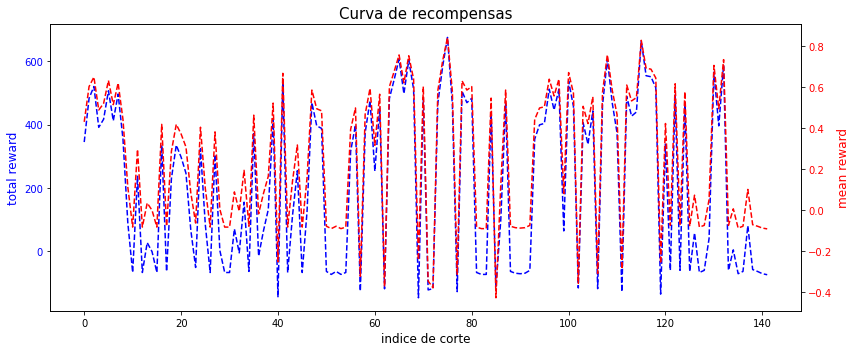

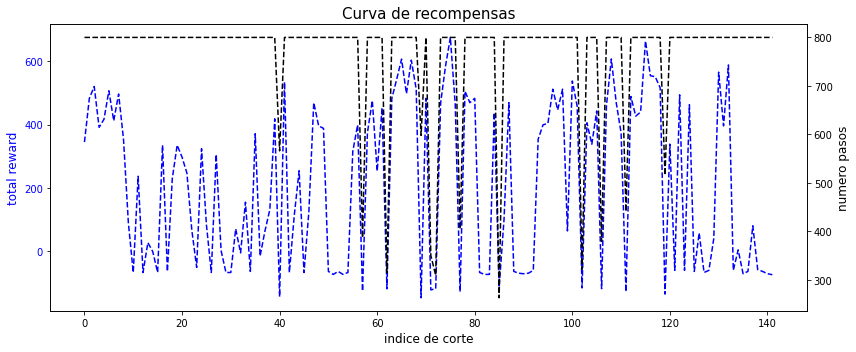

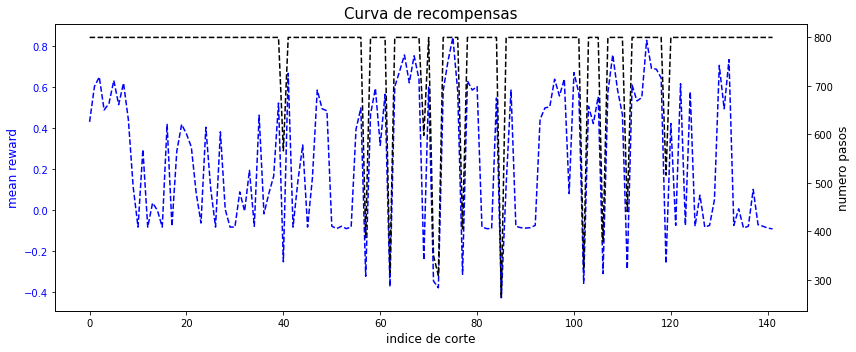

In [33]:
# [RESULTADOS] Ver graficas de curvas

def grafica_curvas(titulo,var_comun,titulox,var1,color1,titulo1,var2,color2,titulo2,figx=12,figy=5):

    fig, ax1 = plt.subplots(figsize=(figx,figy))
    ax1.plot(resultado_fit[var_comun],resultado_fit[var1], color1 + '--')
    ax1.set_ylabel(titulo1, color=color1,fontsize=12) 
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.set_xlabel(titulox,fontsize=12)

    ax2 = ax1.twinx()
    ax2.plot(resultado_fit[var_comun],resultado_fit[var2], color2 + '--')
    ax2.set_ylabel(titulo2, color=color2,fontsize=12)
    ax2.tick_params(axis='y', labelcolor=color2)

    plt.title(titulo,fontsize=15)
    fig.tight_layout() 
    plt.show()
    
grafica_curvas("Curva de recompensas","indice","indice de corte","rew_total","b","total reward","rew_mean","r","mean reward")
grafica_curvas("Curva de recompensas","indice","indice de corte","rew_total","b","total reward","num_pasos","k","numero pasos")
grafica_curvas("Curva de recompensas","indice","indice de corte","rew_mean","b","mean reward","num_pasos","k","numero pasos")

In [34]:
# "Mayor valor de reward total" (POSITIVO)
val_min = 0
resultado_fit[resultado_fit["rew_total"] > val_min].sort_values(["rew_total","num_pasos"],ascending=[False,True])

,indice,epoch,seed_test,eps_train,eps_test,pasos_act_repet,pasos_warmpup,num_pasos,rew_mean,rew_total,archivo,pesos_origen
75,75.0,6000.0,27.0,0.125000,0.125000,4.0,3.0,800.0,0.843396,674.716981,CarRacing_v8_1/wgt_trained1_6000.h5f,CarRacing_v7_4/wgt_trained2_5520.h5f
115,115.0,9200.0,27.0,0.125000,0.125000,4.0,3.0,800.0,0.829245,663.396226,CarRacing_v8_1/wgt_trained1_9200.h5f,CarRacing_v7_4/wgt_trained2_5520.h5f
108,108.0,8640.0,27.0,0.125000,0.125000,4.0,3.0,800.0,0.758491,606.792453,CarRacing_v8_1/wgt_trained1_8640.h5f,CarRacing_v7_4/wgt_trained2_5520.h5f
65,65.0,5200.0,33.0,0.125000,0.125000,4.0,3.0,800.0,0.757843,606.274510,CarRacing_v8_1/wgt_trained1_5200.h5f,CarRacing_v7_4/wgt_trained2_5520.h5f
67,67.0,5360.0,27.0,0.125000,0.125000,4.0,3.0,800.0,0.753774,603.018868,CarRacing_v8_1/wgt_trained1_5360.h5f,CarRacing_v7_4/wgt_trained2_5520.h5f
...,...,...,...,...,...,...,...,...,...,...,...,...
126,126.0,10080.0,6.0,0.125000,0.125000,4.0,3.0,800.0,0.072830,58.263666,CarRacing_v8_1/wgt_trained1_10080.h5f,CarRacing_v7_4/wgt_trained2_5520.h5f
129,129.0,10320.0,33.0,0.125000,0.125000,4.0,3.0,800.0,0.051144,40.915033,CarRacing_v8_1/wgt_trained1_10320.h5f,CarRacing_v7_4/wgt_trained2_5520.h5f
13,13.0,1040.0,33.0,0.159886,0.159886,4.0,3.0,800.0,0.034804,27.843137,CarRacing_v8_1/wgt_trained1_1040.h5f,CarRacing_v7_4/wgt_trained2_5520.h5f
134,134.0,10720.0,33.0,0.125000,0.125000,4.0,3.0,800.0,0.006209,4.967320,CarRacing_v8_1/wgt_trained1_10720.h5f,CarRacing_v7_4/wgt_trained2_5520.h5f


In [35]:
# Indicar indice de testo

indice_modelo = 75
print("Indice de modelo seleccionado:",indice_modelo)

Indice de modelo seleccionado: 75


In [48]:
# Cambiar lista de semilla de ambientes [malo,medio,bueno]

semilla_env = env_bueno
print('Semilla de ambiente:',semilla_env)

Semilla de ambiente: [6, 27, 33, 2, 4, 38]


In [50]:
# [SIMULACION DE TESTEO - FIJO] Evaluar rendimiento de agente/politica aprendida

archivo_lee = resultado_fit.loc[indice_modelo,"archivo"]
print(pd.DataFrame(resultado_fit.loc[indice_modelo,:]))
print('Archivo leido:',archivo_lee)

semillav = 6

# Asignar pesos a modelo
dqn_final = dqn
dqn_final.load_weights(archivo_lee)

visualiza_test(dqn_final,gym_evn=gym_env,n_pasos=2000,
               n_pasos_total=8000,
               eps_actua = 0.0,
               max_episodios=1,
               lap_percent=lap_percent,
               accion_adelanta = 3, # indicar valor para accion de "avanzar" - valor ya definidos
               accion_retrocede = 4, # indicar valor para accion de "retroceder" - valor ya definido
               n_pasos_limite_adelante = 20, # cantidad maxima de pasos "adelante" para aplicar medida de freno (retroceso)
               n_pasos_reinicia_otro = 12, # segun la cantidad de pasos seguidos "adelante" reinicia contrador "otro"
               n_pasos_reinicia_adelante = 5, # segun la cantidad de pasos seguidos "otro" reinicia contrador "adelante"
               random_color_envp = 1, # cambiar color de fondo aleatoriamente
               seed_env= semillav, # semilla
               imprime=False)

                                                   75
indice                                           75.0
epoch                                          6000.0
seed_test                                        27.0
eps_train                                       0.125
eps_test                                        0.125
pasos_act_repet                                   4.0
pasos_warmpup                                     3.0
num_pasos                                       800.0
rew_mean                                     0.843396
rew_total                                  674.716981
archivo          CarRacing_v8_1/wgt_trained1_6000.h5f
pesos_origen     CarRacing_v7_4/wgt_trained2_5520.h5f
Archivo leido: CarRacing_v8_1/wgt_trained1_6000.h5f


In [41]:
# [SIMULACION DE TESTEO - DINAMICO] Evaluar rendimiento de agente/politica aprendida

semillav = semilla(semillas=semilla_env,k=1)
archivo_lee = resultado_fit.loc[indice_modelo,"archivo"]
print(pd.DataFrame(resultado_fit.loc[indice_modelo,:]))
print('Archivo leido:',archivo_lee)
print('Semilla entorno:',semillav)

# Asignar pesos a modelo
dqn_final = dqn
dqn_final.load_weights(archivo_lee)

# cantidad de episodios maxima
max_episodios = 1

for iix in range(max_episodios):
    
    # valor aleatorio
    semillav = semilla(semillas=semilla_env,k=1)
    
    # invocar testeo
    visualiza_test(dqn_final,gym_evn=gym_env,n_pasos=2000,
                   n_pasos_total=8000,
                   eps_actua = 0.0,
                   max_episodios= 1,
                   lap_percent=lap_percent,
                   accion_adelanta = 3, # indicar valor para accion de "avanzar" - valor ya definidos
                   accion_retrocede = 4, # indicar valor para accion de "retroceder" - valor ya definido
                   n_pasos_limite_adelante = 20, # cantidad maxima de pasos "adelante" para aplicar medida de freno (retroceso)
                   n_pasos_reinicia_otro = 12, # segun la cantidad de pasos seguidos "adelante" reinicia contrador "otro"
                   n_pasos_reinicia_adelante = 5, # segun la cantidad de pasos seguidos "otro" reinicia contrador "adelante"
                   random_color_envp = 1, # cambiar color de fondo aleatoriamente
                   seed_env= semillav,
                   imprime=False)

                                                   75
indice                                           75.0
epoch                                          6000.0
seed_test                                        27.0
eps_train                                       0.125
eps_test                                        0.125
pasos_act_repet                                   4.0
pasos_warmpup                                     3.0
num_pasos                                       800.0
rew_mean                                     0.843396
rew_total                                  674.716981
archivo          CarRacing_v8_1/wgt_trained1_6000.h5f
pesos_origen     CarRacing_v7_4/wgt_trained2_5520.h5f
Archivo leido: CarRacing_v8_1/wgt_trained1_6000.h5f
Semilla entorno: 6


In [37]:
# [ACTUALIZA MODELO - TRANSFIERE PESOS] Actualizar agente segun pesos de modelo entrenado

archivo_lee = resultado_fit.loc[indice_modelo,"archivo"]
print(pd.DataFrame(resultado_fit.loc[indice_modelo,:]))
print('Archivo leido:',archivo_lee)

# Asignar pesos a modelo
dqn= dqn
dqn.load_weights(archivo_lee)

                                                   75
indice                                           75.0
epoch                                          6000.0
seed_test                                        27.0
eps_train                                       0.125
eps_test                                        0.125
pasos_act_repet                                   4.0
pasos_warmpup                                     3.0
num_pasos                                       800.0
rew_mean                                     0.843396
rew_total                                  674.716981
archivo          CarRacing_v8_1/wgt_trained1_6000.h5f
pesos_origen     CarRacing_v7_4/wgt_trained2_5520.h5f
Archivo leido: CarRacing_v8_1/wgt_trained1_6000.h5f


In [ ]:
# [ADICIONAL - NO OBLIGATORIO] Ver capas 2D aprendidas (Conv2D)

try:
    capas = [capa for capa in dqn.model.layers]
    capas = [capa for capa in dqn.model.layers if "convolutional.conv2d" in str(capa)]
    capas = capas[::-1] # invertir el orden de capas
except:
    capas = [capa for capa in dqn_final.model.layers]
    capas = [capa for capa in dqn_final.model.layers if "convolutional.conv2d" in str(capa)]
    capas = capas[::-1] # invertir el orden de capas
    
for capa in capas:
    pesos, bias = capa.get_weights()
    
    try:
        n1, n2 = pesos.shape[0], pesos.shape[1]
        fig, axs = plt.subplots(n1,n2,figsize=(12,20))

        images = []
        for i in range(n1):
            for j in range(n2):
                print('Capa :',str(capa))
                imagen = pesos[i,j,:,:].copy()
                imagen = 255*(imagen - imagen.min(axis=0))/(imagen.max(axis=0) - imagen.min(axis=0)) # Escalar imagen
                images.append(axs[i, j].imshow(imagen)) # se puede colocar gris: cmap="gray"
                axs[i, j].label_outer()
        plt.show()
        
    except:
        pass

#### 4) Utilizacion de capas de modelo entrenado

0 :  <keras.layers.reshaping.reshape.Reshape object at 0x0000019A62F62670>
1 :  <keras.layers.reshaping.cropping2d.Cropping2D object at 0x0000019A63818370>
2 :  <keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x0000019A6705DD00>
3 :  <keras.layers.convolutional.conv2d.Conv2D object at 0x0000019A6CF44790>
4 :  <keras.layers.core.activation.Activation object at 0x0000019A6CF41CA0>
5 :  <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x0000019A6CF41BE0>
6 :  <keras.layers.regularization.dropout.Dropout object at 0x0000019A6CF5D730>
7 :  <keras.layers.convolutional.conv2d.Conv2D object at 0x0000019A6CF44BE0>
8 :  <keras.layers.core.activation.Activation object at 0x0000019A6CF80C70>
9 :  <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x0000019A6CF80B80>
10 :  <keras.layers.regularization.dropout.Dropout object at 0x0000019A6CF9C400>
11 :  <keras.layers.convolutional.conv2d.Conv2D object at 0x0000019A6CF8FEE0>
12 :  <keras.layers.core.activation.Ac

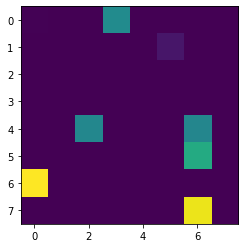

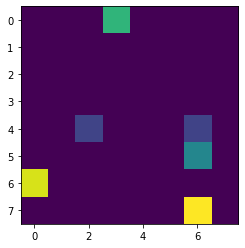

In [110]:
# Ejemplo de reuso de capas de modelo entrenado

# Capas de modelo
capas = [capa for capa in dqn.model.layers]

for i in  range(len(capas)):
    print(i,': ',capas[i])
    
######################################

# Creacion de modelo con capas de modelo
model_inputs = dqn.model.inputs
model_outputs = dqn.model.layers[20].output

# Modelo
model_trained = tf.keras.models.Model(
    inputs= model_inputs,
    outputs=model_outputs)

# Ver modelo
print(model_trained.summary())

## Prediccion con imagen en modelo
prediction = model_trained.predict(observation[np.newaxis,np.newaxis,:,:,:])

# Ejemplo de imagen con prediccion
plt.imshow(np.reshape(prediction,(2,8,8))[0,:,:])
plt.show()

plt.imshow(np.reshape(prediction,(2,8,8))[1,:,:])
plt.show()